In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from swmm_api import read_inp_file

In [3]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape,r2_score as r2,zero_one_loss as zo

# shunqing

In [3]:
cwd = './results/shunqing/10s_res_norm/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [4]:
from utilities import get_inp_files
from envs import get_env
env = get_env('shunqing')()
# train_id = np.load('./model/shunqing/5s_20k_edge_res_norm_flood/train_id.npy')
# events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
# [event for idx,event in enumerate(events) if idx not in train_id]

In [62]:
event = 'bpswmm_2413'
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

## Rainfalls

In [1]:
from utilities import get_inp_files
from envs import get_env
from matplotlib import pyplot as plt
from swmm_api import read_inp_file
env = get_env('shunqing')()
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])

In [16]:
evs = {}
for event in events:
    if event.split('_')[1].startswith('16'):
        inp = read_inp_file(event)
        name = inp.RAINGAGES['RainGage'].Timeseries
        tss = inp.TIMESERIES[name].data
        evs[name] = sum([ts[1] for ts in tss])
evs

{'bpswmm_161': 173.2,
 'bpswmm_162': 31.099999999999998,
 'bpswmm_163': 39.30000000000001,
 'bpswmm_164': 26.900000000000002,
 'bpswmm_165': 56.800000000000004,
 'bpswmm_166': 52.99999999999999,
 'bpswmm_167': 108.99999999999999,
 'bpswmm_168': 32.7,
 'bpswmm_169': 25.700000000000003,
 'bpswmm_1610': 50.599999999999994,
 'bpswmm_1611': 75.69999999999999,
 'bpswmm_1612': 51.9}

**3 testing events in shunqing**

R11,bpswmm_118,54.4,
R13,bpswmm_137,34.4
R16,bpswmm_164,26.9

In [9]:
for event in events:
    inp = read_inp_file(event)
    name = inp.RAINGAGES['RainGage'].Timeseries
    tss = inp.TIMESERIES[name].data
    plt.plot([ts[1] for ts in tss],label=name)
# plt.legend()

## Nodes

In [4]:
event = 'test_bpswmm_137'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


In [7]:
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

In [32]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=50,alpha=0.2)

In [8]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [58]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = pd.MultiIndex.from_tuples([(a,b) for a in columns for b in metrics]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results[columns[i],metrics[j]] = [metric(true[:,idx,:,i],pred[:,idx,:,i]) for idx in range(true.shape[1])]
results[[(a,'RMSE') for a in columns]] = np.sqrt(results[[(a,'RMSE') for a in columns]].to_numpy())
results[('Total inflow','R2')] = [metric(true[:,idx,:,1][:,np.abs(true[:,idx,:,1]).max(axis=0)>1e-6],pred[:,idx,:,1][:,np.abs(true[:,idx,:,1]).max(axis=0)>1e-6]) for idx in range(true.shape[1])]
results

Water depth                     Total inflow                      \
         RMSE       MAE        R2         RMSE       MAE        R2   
0    0.006644  0.003242  0.993362     1.174963  0.436554  0.703848   
1    0.006321  0.002946  0.993777     1.168937  0.431320  0.701380   
2    0.006053  0.003006  0.993704     1.171686  0.431890  0.700305   
3    0.006118  0.003064  0.993922     1.173586  0.433392  0.699343   
4    0.006249  0.002991  0.994861     1.178861  0.436534  0.701124   

  Total outflow                      Flooding                      
           RMSE       MAE        R2      RMSE       MAE        R2  
0      0.373681  0.162605  0.987895  0.179623  0.008959  0.998311  
1      0.374655  0.160601  0.987525  0.180843  0.009421  0.998288  
2      0.370219  0.157997  0.988317  0.183874  0.009318  0.998230  
3      0.367775  0.158446  0.988341  0.184677  0.009188  0.998215  
4      0.362660  0.159038  0.988358  0.184737  0.009137  0.998214

In [35]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_pred[...,i])
# results.loc['R2','Water depth'] = metric(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results

Water depth Total inflow Total outflow  Flooding
RMSE    0.080015     2.822591      2.393149  1.320655
MAE      0.04942     2.257764      1.828575  1.002607
R2     -1.364558     0.115466      0.139695  0.848349

- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes: not significant
    - Water level error makes up with small loss: Normalization works
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

#### Element-wise

In [246]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]

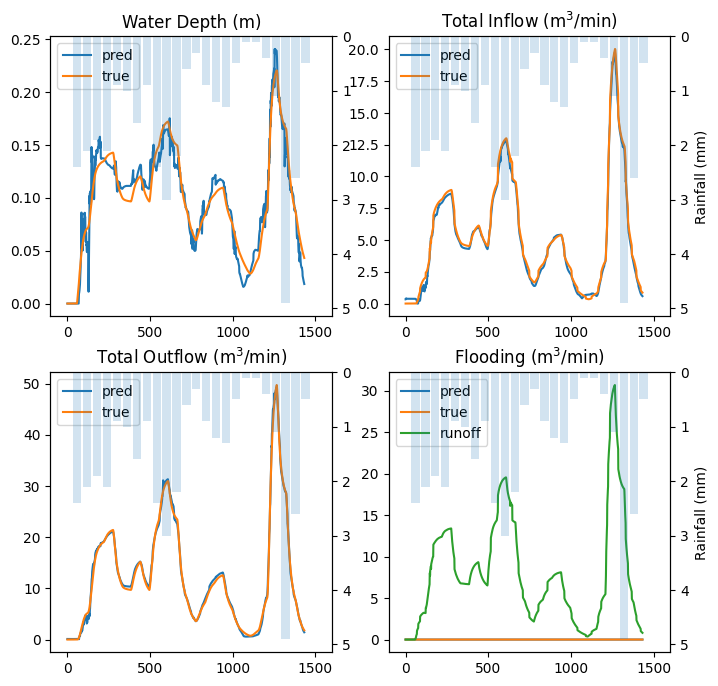

In [247]:
idx = nodes.index('jd27')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes)-1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == -1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if i in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [248]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

Water depth Total inflow Total outflow Flooding
RMSE    0.000193     0.125643      0.333861      0.0
MAE     0.011043     0.290736      0.424861      0.0
R2      0.914229     0.993373      0.996952      1.0

## Edges

In [36]:
event = 'bpswmm_2413'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(1434, 5, 131, 3)

In [37]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')



Text(0, 0.5, 'Rainfall (mm)')

In [39]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results

Link depth Link volume Link flow
RMSE   0.005007    2.345153  0.562051
MAE    0.003248    1.798846  0.376665
R2     0.995083    0.992616   0.95384

#### Element-wise

In [257]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
links = [k for k in list(inp.CONDUITS)]


In [258]:
seq = -1
idx = links.index('GQ76')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')


Text(0, 0.5, 'Rainfall (mm)')

In [259]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results

Link depth Link volume Link flow
RMSE   0.000011    0.141616  1.251363
MAE    0.002555    0.305213  0.955956
R2     0.997543    0.996368   0.99171

## Conv-NN comparison

In [34]:
event = 'test_bpswmm_118'
from envs import get_env
env = get_env('shunqing')()
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

In [37]:
cwd = './results/shunqing/10s_20k_10o_edge_res_norm_flood_nn_head/'
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('edge','edgef').replace('nn','gat'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('edge','edgef').replace('nn','gat'),event+'_edge_pred.npy'))
# fpred2 = np.load(os.path.join(cwd.replace('nn','gat').replace('1000k','10o'),event+'_pred.npy'))
# edge_fpred2 = np.load(os.path.join(cwd.replace('nn','gat').replace('1000k','10o'),event+'_edge_pred.npy'))

### Overall prediction

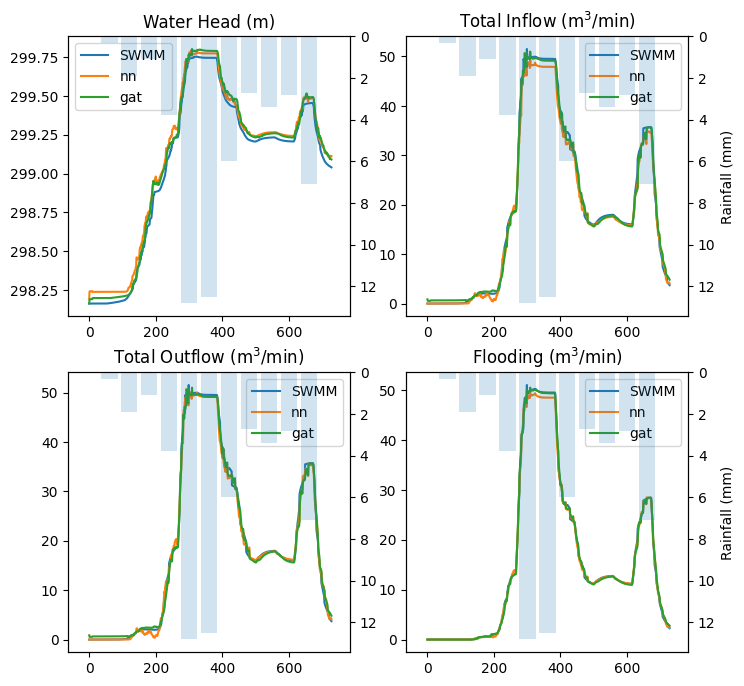

In [38]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Head (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='SWMM')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='nn')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='gat')
    # ax.plot(fpred2[:,seq,...].mean(axis=1)[:,idx],label='gat')
    # if idx == -1:
    #     ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [11]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(true,(0,2,1,3)),(-1,true.shape[1],true.shape[-1]))
y_pred = np.reshape(np.transpose(pred,(0,2,1,3)),(-1,pred.shape[1],pred.shape[-1]))
y_fpred = np.reshape(np.transpose(fpred,(0,2,1,3)),(-1,fpred.shape[1],fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(fpred2,(0,2,1,3)),(-1,fpred2.shape[1],fpred2.shape[-1]))
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Water depth    0.112644  0.057642  0.107386  0.051412
Total inflow   1.751529  0.883213  1.663439  0.784568
Total outflow  1.502967  0.947969  1.405360  0.841138
Flooding       0.807365  0.506706  0.744544  0.438650

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = -1

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='SWMM')
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='nn')
    ax.plot(edge_fpred[:,seq,...].mean(axis=1)[:,idx],label='gat')
    # ax.plot(edge_fpred2[:,seq,...].mean(axis=1)[:,idx],label='gat')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')

Text(0, 0.5, 'Rainfall (mm)')

In [13]:
columns = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(edge_true,(0,2,1,3)),(-1,edge_true.shape[1],edge_true.shape[-1]))
y_pred = np.reshape(np.transpose(edge_pred,(0,2,1,3)),(-1,edge_pred.shape[1],edge_pred.shape[-1]))
y_fpred = np.reshape(np.transpose(edge_fpred,(0,2,1,3)),(-1,edge_fpred.shape[1],edge_fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(edge_fpred2,(0,2,1,3)),(-1,edge_fpred2.shape[1],edge_fpred2.shape[-1]))
for i in [0,1,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Link depth (m)                       0.008141  0.005746  0.007205  0.005017
Link volume ($\mathregular{m^3}$)    2.766451  2.327811  2.364537  2.033482
Link flow ($\mathregular{m^3}$/min)  1.239642  0.858055  1.060559  0.761675

### Element-level prediction

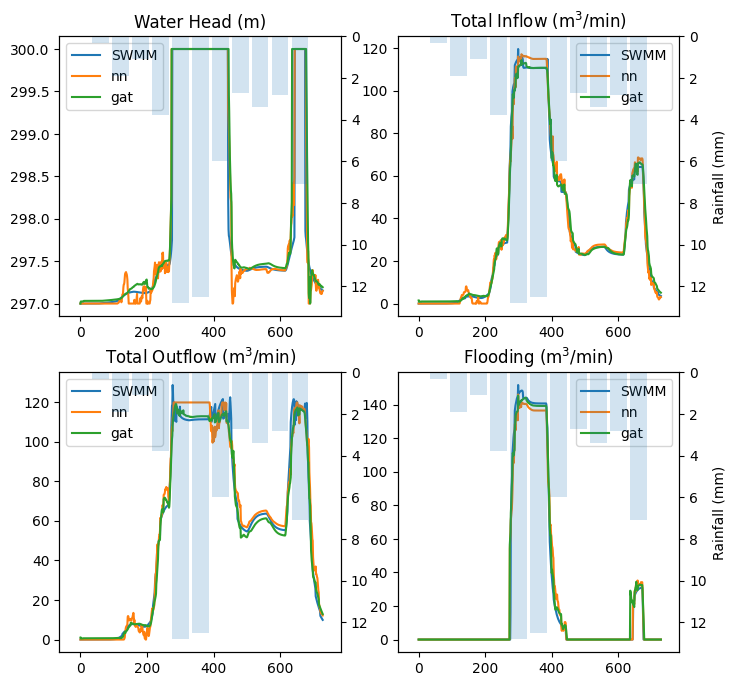

In [14]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]
idx = nodes.index('jd43')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Head (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes)-1:
        i = -1
    ax.plot(true[:,seq,idx,i],label='SWMM')
    ax.plot(pred[:,seq,idx,i],label='nn')
    ax.plot(fpred[:,seq,idx,i],label='gat')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if i in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [15]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = true[...,idx,:]
y_pred = pred[...,idx,:]
y_fpred = fpred[...,idx,:]
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Water depth    0.088796  0.108403  0.067853  0.081430
Total inflow   1.969517  1.488705  1.829946  1.324812
Total outflow  3.904105  2.380090  3.589678  2.071123
Flooding       2.439109  1.474795  2.139525  1.120958

Text(0, 0.5, 'Rainfall (mm)')

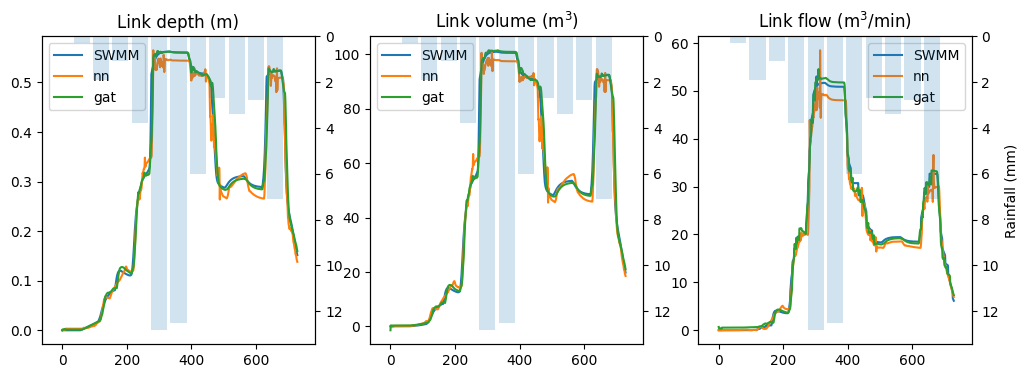

In [16]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
links = [k for k in list(inp.CONDUITS)]
seq = 5
idx = links.index('GQ45')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_true[:,seq,idx,i],label='SWMM')
    ax.plot(edge_pred[:,seq,idx,i],label='nn')
    ax.plot(edge_fpred[:,seq,idx,i],label='gat')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')

In [17]:
columns = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
results = pd.DataFrame()
y_true = edge_true[...,idx,:]
y_pred = edge_pred[...,idx,:]
y_fpred = edge_fpred[...,idx,:]
for i in [0,1,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Link depth (m)                       0.015336  0.009304  0.013785  0.008180
Link volume ($\mathregular{m^3}$)    2.595039  1.678778  2.323378  1.461579
Link flow ($\mathregular{m^3}$/min)  1.591385  0.790580  1.406762  0.712539

### Train loss

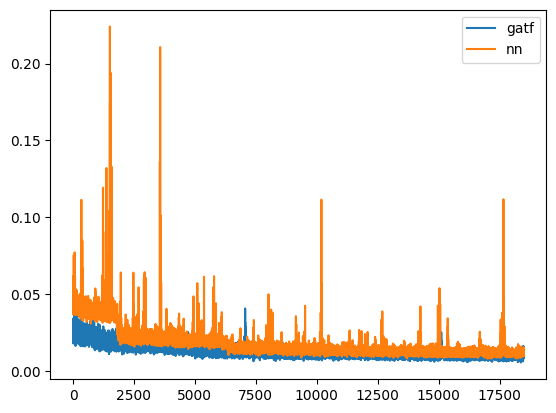

In [31]:
import matplotlib.pyplot as plt
cwd = './model/shunqing/'
# gat_train = np.load(os.path.join(cwd,'10s_20k_10o_edge_res_norm_flood_gat','train_loss.npy'))
gatf_train = np.load(os.path.join(cwd,'10s_20k_10o_edgef_res_norm_flood_qw_gat_head','train_loss.npy'))
nn_train = np.load(os.path.join(cwd,'10s_20k_10o_edge_res_norm_flood_nn_head','train_loss.npy'))
# plt.plot(gat_train[1000:],label='gat')
plt.plot([min(train,0.06) for train in gatf_train[1000:]],label='gatf')
plt.plot(nn_train[1000:],label='nn')
plt.legend()

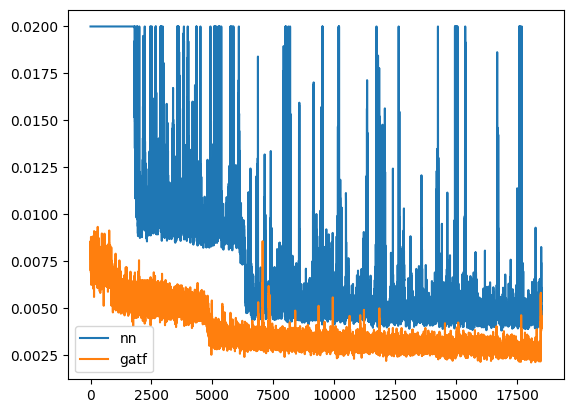

In [46]:
cwd = './model/shunqing/'
# gat_test = np.load(os.path.join(cwd,'10s_20k_10o_edge_res_norm_flood_gat','test_loss.npy'))
gatf_test = np.load(os.path.join(cwd,'10s_20k_10o_edgef_res_norm_flood_qw_gat_head','test_loss.npy'))
nn_test = np.load(os.path.join(cwd,'10s_20k_10o_edge_res_norm_flood_nn_head','test_loss.npy'))
# plt.plot([test[1] for test in gat_test[1000:]],label='gat')
plt.plot([min(test[0],0.02) for test in nn_test[1000:]],label='nn')
plt.plot([test[0] for test in gatf_test[1000:]],label='gatf')
plt.legend()

### Parameters

In [5]:
from emulator import Emulator
import yaml,argparse,os
from functools import reduce
from envs import shunqing
env = shunqing()
env_args = env.get_args()

hyps = yaml.load(open('config.yaml','r'),yaml.FullLoader)
margs = argparse.Namespace(**hyps['shunqing'])

In [6]:
env_args['state_shape'] = (10000,4)
env_args['edge_state_shape'] = (10000,3)

In [7]:
cwd = './model/shunqing/5s_20k_res_norm_flood_nn/'
margs.model_dir = cwd
known_hyps = yaml.load(open(os.path.join(margs.model_dir,'parser.yaml'),'r'),yaml.FullLoader)
for k,v in list(known_hyps.items())+list(env_args.items()):
    if k == 'model_dir':
        continue
    setattr(margs,k,v)
margs.use_edge = margs.use_edge or margs.edge_fusion
emul = Emulator(margs.conv,margs.resnet,margs.recurrent,margs)
variables = emul.model.trainable_variables
params = [reduce(lambda x,y:x*y,list(var.get_shape())) for var in variables]
sum(params)

29855376

In [8]:
cwd = './model/shunqing/5s_20k_res_norm_flood_gat/'
margs.model_dir = cwd
known_hyps = yaml.load(open(os.path.join(margs.model_dir,'parser.yaml'),'r'),yaml.FullLoader)
for k,v in list(known_hyps.items())+list(env_args.items()):
    if k == 'model_dir':
        continue
    setattr(margs,k,v)
margs.use_edge = margs.use_edge or margs.edge_fusion
emul = Emulator(margs.conv,margs.resnet,margs.recurrent,margs)
variables = emul.model.trainable_variables
params = [reduce(lambda x,y:x*y,list(var.get_shape())) for var in variables]
sum(params)

370373

## Node-edge fusion comparison

In [42]:
# event = 'bpswmm_2413'
# cwd = './results/shunqing/5s_edge_res_norm_flood/'
event = 'test_bpswmm_164'
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES['RainGage'].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]
cwd = './results/shunqing/10s_res_norm_edge/'
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_edge_pred.npy'))

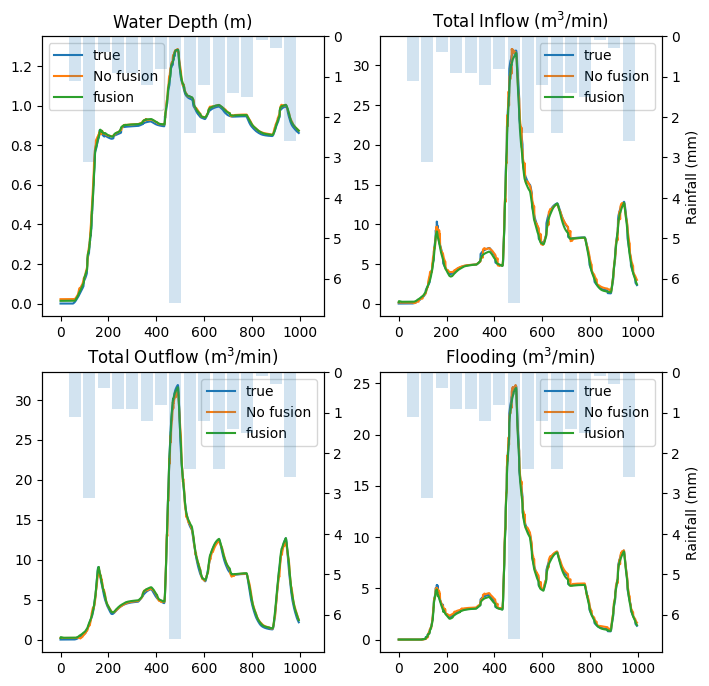

In [8]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='No fusion')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='fusion')
    # if idx == -1:
    #     ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [13]:

columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(true,(0,2,1,3)),(-1,true.shape[1],true.shape[-1]))
y_pred = np.reshape(np.transpose(pred,(0,2,1,3)),(-1,pred.shape[1],pred.shape[-1]))
y_fpred = np.reshape(np.transpose(fpred,(0,2,1,3)),(-1,fpred.shape[1],fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(fpred2,(0,2,1,3)),(-1,fpred2.shape[1],fpred2.shape[-1]))
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_no'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_fusion'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_no'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_fusion'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_no  RMSE_fusion    MAE_no  MAE_fusion
Water depth    0.013817     0.009863  0.011676    0.008234
Total inflow   0.460490     0.421418  0.402801    0.383518
Total outflow  0.421344     0.259184  0.375955    0.233165
Flooding       0.230128     0.197028  0.199861    0.175375

Text(0, 0.5, 'Rainfall (mm)')

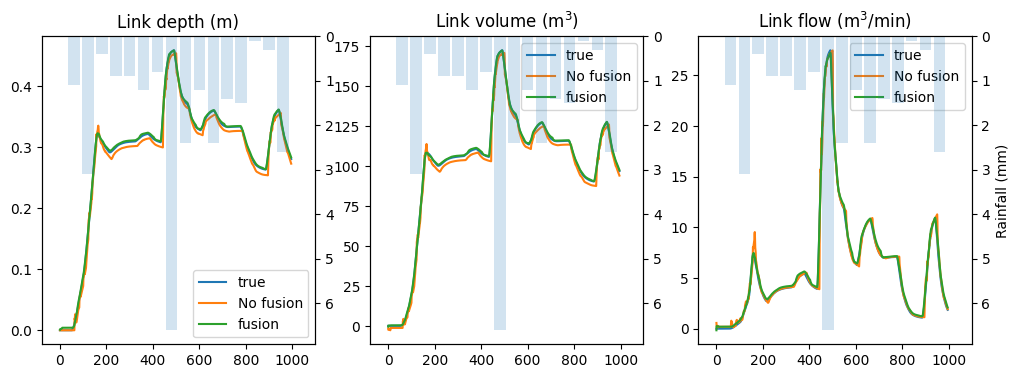

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = -1

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='No fusion')
    ax.plot(edge_fpred[:,seq,...].mean(axis=1)[:,idx],label='fusion')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')


In [14]:
columns = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(edge_true,(0,2,1,3)),(-1,edge_true.shape[1],edge_true.shape[-1]))
y_pred = np.reshape(np.transpose(edge_pred,(0,2,1,3)),(-1,edge_pred.shape[1],edge_pred.shape[-1]))
y_fpred = np.reshape(np.transpose(edge_fpred,(0,2,1,3)),(-1,edge_fpred.shape[1],edge_fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(edge_fpred2,(0,2,1,3)),(-1,edge_fpred2.shape[1],edge_fpred2.shape[-1]))
for i in [0,1,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_no'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_fusion'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_no'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_fusion'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
results

RMSE_no  RMSE_fusion    MAE_no  \
Link depth (m)                       0.006076     0.002340  0.005510   
Link volume ($\mathregular{m^3}$)    2.282386     0.755120  2.085281   
Link flow ($\mathregular{m^3}$/min)  0.414366     0.233754  0.353193   

                                     MAE_fusion  
Link depth (m)                         0.002147  
Link volume ($\mathregular{m^3}$)      0.690008  
Link flow ($\mathregular{m^3}$/min)    0.209822

Text(0, 0.5, 'Rainfall (mm)')

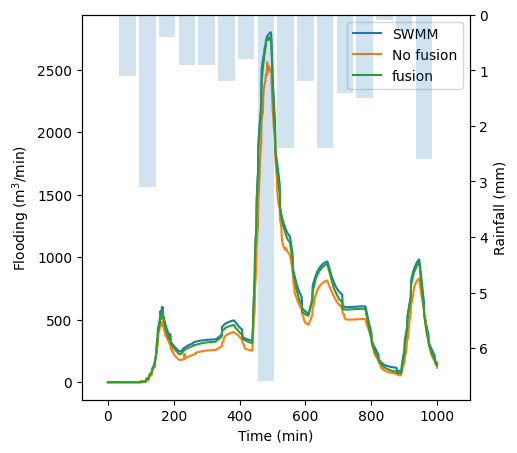

In [46]:
event = 'bpswmm_164'

inp = read_inp_file('./envs/network/shunqing/test_'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES['test_'+event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

cwd = './results/shunqing/5s_edge_res_norm_flood/'
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_edge_pred.npy'))

fig,ax = plt.subplots(1,1,figsize=(5,5))
seq = -1
ax.plot(true[:,seq,...].sum(axis=1)[:,-1],label='SWMM')
ax.plot(pred[:,seq,...].sum(axis=1)[:,-1],label='No fusion')
ax.plot(fpred[:,seq,...].sum(axis=1)[:,-1],label='fusion')
ax.legend()
ax.set_xlabel('Time (min)')
ax.set_ylabel('Flooding ($\mathregular{m^3}$/min)')
axx = ax.twinx()
axx.invert_yaxis()
axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')

## Flood determination

In [33]:
event = 'bpswmm_164'
inp = read_inp_file('./envs/network/shunqing/test_'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES['test_'+event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

cwd = './results/shunqing/5s_edgef_res_norm/'
true = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_true.npy'))
edge_true = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_pred.npy'))
edge_bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_pred.npy'))

In [39]:
event = 'test_bpswmm_164'
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

cwd = './results/shunqing/10s_20k_10o_edgef_res_norm_gat_head/'
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_pred.npy'))
edge_bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_edge_pred.npy'))
true = np.load(os.path.join(cwd.replace('_norm','_norm_flood_qw'),event+'_true.npy'))
edge_true = np.load(os.path.join(cwd.replace('_norm','_norm_flood_qw'),event+'_edge_true.npy'))
fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood_qw'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood_qw'),event+'_edge_pred.npy'))

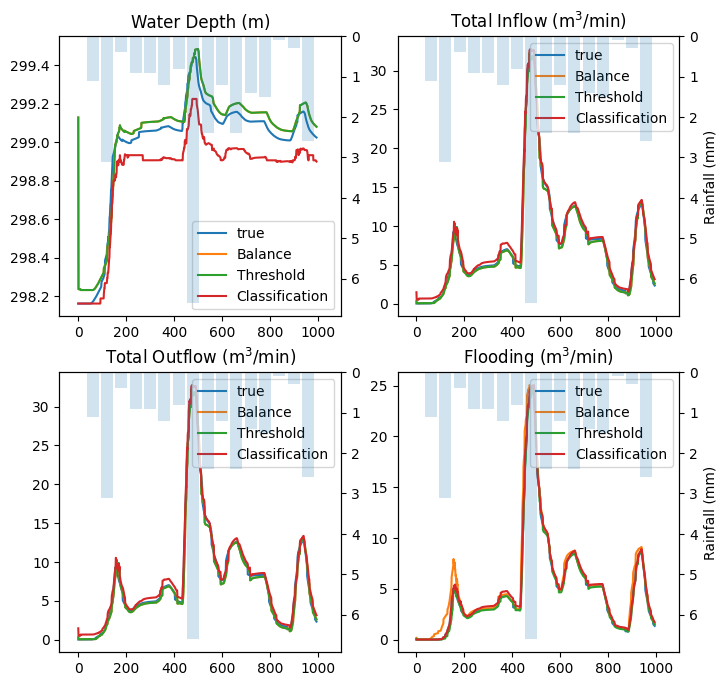

In [40]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(bpred[:,seq,...].mean(axis=1)[:,idx],label='Balance')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='Threshold')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='Classification')
    # if idx == -1:
    #     ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

Text(0, 0.5, 'Rainfall (mm)')

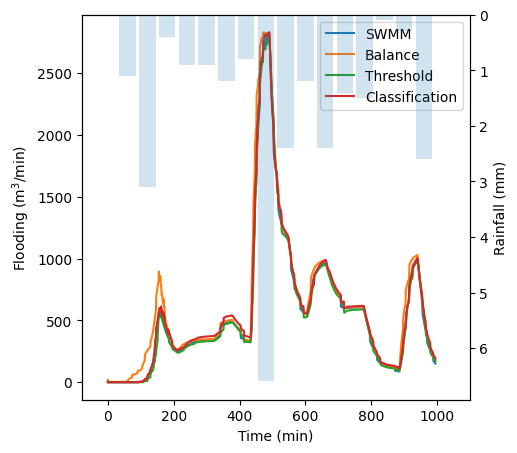

In [41]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
seq = -1
ax.plot(true[:,seq,...].sum(axis=1)[:,-1],label='SWMM')
ax.plot(bpred[:,seq,...].sum(axis=1)[:,-1],label='Balance')
ax.plot(pred[:,seq,...].sum(axis=1)[:,-1],label='Threshold')
ax.plot(fpred[:,seq,...].sum(axis=1)[:,-1],label='Classification')
ax.legend()
ax.set_xlabel('Time (min)')
ax.set_ylabel('Flooding ($\mathregular{m^3}$/min)')
axx = ax.twinx()
axx.invert_yaxis()
axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')

In [42]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],pred.shape[-1]))
y_bpred = np.reshape(bpred,(-1,bpred.shape[-2],bpred.shape[-1]))
y_fpred = np.reshape(fpred,(-1,fpred.shape[-2],fpred.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j]+' Balance',columns[i]] = metric(y_true[...,i],y_bpred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_bpred[...,i])
        results.loc[metrics[j]+' Threshold',columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
        results.loc[metrics[j]+' Classification',columns[i]] = metric(y_true[...,i],y_fpred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_fpred[...,i])

# results.loc['R2','Water depth'] = metric(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2 Balance','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_bpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 Threshold','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 Classification','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_fpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results

Water depth Total inflow Total outflow  Flooding
RMSE Balance           0.105214     0.760127      0.830492  1.419211
RMSE Threshold         0.105214     0.760127      0.830492  0.510773
RMSE Classification     0.20816      0.69207      0.757591  0.390831
MAE Balance            0.044229     0.435083      0.455585  0.640496
MAE Threshold          0.044229     0.435083      0.455585   0.21442
MAE Classification     0.155842     0.461592      0.489984  0.196539
R2 Balance            -0.786131     0.971868      0.956787 -7.467734
R2 Threshold          -0.786131     0.971868      0.956787  0.642113
R2 Classification     -2.112579     0.968587      0.965855  0.883473

In [45]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(true,(0,2,1,3)),(-1,true.shape[1],true.shape[-1]))
y_pred = np.reshape(np.transpose(pred,(0,2,1,3)),(-1,pred.shape[1],pred.shape[-1]))
y_bpred = np.reshape(np.transpose(bpred,(0,2,1,3)),(-1,bpred.shape[1],bpred.shape[-1]))
y_fpred = np.reshape(np.transpose(fpred,(0,2,1,3)),(-1,fpred.shape[1],fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(fpred2,(0,2,1,3)),(-1,fpred2.shape[1],fpred2.shape[-1]))
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_Balance'] = mse(y_true[...,i].T,y_bpred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_Threshold'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_Classification'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_Balance'] = mae(y_true[...,i].T,y_bpred[...,i].T)
    results.loc[columns[i],'MAE_Threshold'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_Classification'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_Balance  RMSE_Threshold  RMSE_Classification  MAE_Balance  \
Water depth        0.047652        0.047652             0.159035     0.044229   
Total inflow       0.496813        0.496813             0.520527     0.435083   
Total outflow      0.521905        0.521905             0.552911     0.455585   
Flooding           0.710546        0.247513             0.226622     0.640496   

               MAE_Threshold  MAE_Classification  
Water depth         0.044229            0.155842  
Total inflow        0.435083            0.461592  
Total outflow       0.455585            0.489984  
Flooding            0.214420            0.196539

In [43]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
l_true = np.argmax(true[...,-3:-1],axis=-1).flatten()
l_bpred = (bpred[...,-1]>0).astype(np.int64).flatten()
l_pred = (pred[...,-1]>0).astype(np.int64).flatten()
l_fpred = np.argmax(fpred[...,-3:-1],axis=-1).flatten()
results = pd.DataFrame(columns = ['Balance','Threshold','Classification'])
for met,metric in zip(['Accuracy','Precision','Recall'],[accuracy_score,precision_score,recall_score]):
    results.loc[met] = [metric(l_true,l_p) for l_p in [l_bpred,l_pred,l_fpred]]
results.round(4)

Balance  Threshold  Classification
Accuracy    0.5613     0.9821          0.8946
Precision   0.3090     0.9215          0.6504
Recall      1.0000     0.9936          0.9999

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(l_true,l_bpred).ravel(),confusion_matrix(l_true,l_pred).ravel(),confusion_matrix(l_true,l_fpred).ravel()

(array([411018, 493702,      0, 220760], dtype=int64),
 array([886030,  18690,   1420, 219340], dtype=int64),
 array([785883, 118837,     86, 220674], dtype=int64))

## Debug

### Debug inflow & outflow

In [23]:
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
states = np.load('./envs/data/shunqing/edge/states.npy')[event_id==0]


In [4]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('jd30')
edges = [k for k in list(inp.CONDUITS)]
idxe = [edges.index(e) for e in ['GQ16','GQ38','GQ75','GQ73']]

In [5]:
import pandas as pd
jd = pd.DataFrame()
jd['tot_in'],jd['tot_out'],jd['lat_in'] = states[:,idx,1],states[:,idx,2],states[:,idx,3]
links = ['GQ16','GQ38','GQ75','GQ73']
jd[links] = np.array([edge_states[:,e,-1] for e in idxe]).T
jd

tot_in   tot_out    lat_in      GQ16      GQ38      GQ75      GQ73
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.000000  0.000000  0.000000  0.000000 -0.000000  0.000000  0.000000
2    0.000000  0.000000  0.000000  0.000000 -0.000000  0.000000  0.000000
3    0.000000  0.000000  0.000000  0.000000 -0.000000  0.000000  0.000000
4    0.000000  0.000000  0.000000  0.000000 -0.000000  0.000000  0.000000
..        ...       ...       ...       ...       ...       ...       ...
396  4.263206  4.008364  1.610603  2.526705 -0.403256  0.661647  2.943461
397  4.275959  4.026690  1.614094  2.538565 -0.404979  0.664665  2.957045
398  4.288628  4.044597  1.617667  2.550150 -0.406663  0.667615  2.970319
399  4.301039  4.062131  1.621246  2.561484 -0.408312  0.670503  2.983316
400  1.964714  4.070659  0.740259  2.566651 -0.409168  0.672003  2.989488

[401 rows x 7 columns]

In [18]:
jd['GQ73']+jd['GQ75'] - jd['tot_out']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
396   -0.403256
397   -0.404979
398   -0.406663
399   -0.408312
400   -0.409168
Length: 401, dtype: float64

### Inverse conduits

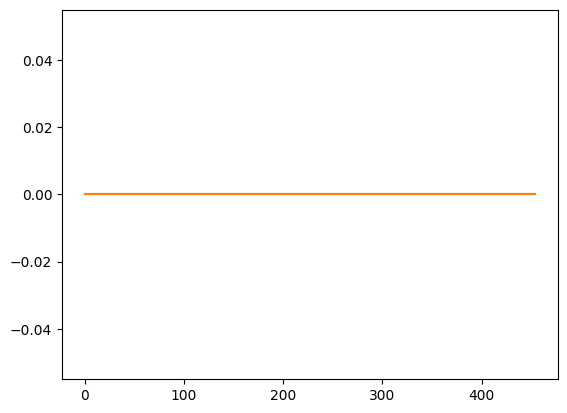

In [27]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
edges = np.array([k for k in list(inp.CONDUITS)])
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
flow = edge_states[...,-2]
inv_edges_idx = (1-np.sum(flow>0,axis=0)>0).nonzero()
for idx in inv_edges_idx:
    plt.plot(flow[:,idx])

In [28]:
edges[inv_edges_idx]

array(['GQ77', 'GQ120'], dtype='<U5')

In [148]:
(1-np.sum(flow>0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  19,  21,  22,  23,  26,  27,  32,
        36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  60,  61,  64,
        68,  76,  77,  79,  84,  85,  86,  87,  94,  97, 102, 103, 105,
       106, 107, 109, 115, 119, 121, 123, 129, 130], dtype=int64)

In [147]:
(np.sum(flow<0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  17,  19,  21,  22,  23,  26,  27,
        28,  32,  36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  59,
        60,  61,  64,  66,  68,  77,  78,  79,  84,  85,  86,  87,  94,
        97, 102, 103, 104, 105, 106, 107, 109, 113, 115, 120, 121, 123,
       129, 130], dtype=int64)

In [153]:
idxs = [idx for idx in (np.sum(flow<0,axis=0)>0).nonzero()[0] if idx not in (1-np.sum(flow>0,axis=0)>0).nonzero()[0]]
for idx in idxs:
    plt.plot(flow[:,idx],label = edges[idx])
plt.legend()

In [157]:
for edge in edges[inv_edges_idx].tolist()+['GQ105']:
    cond = inp['CONDUITS'][edge]
    cond.FromNode,cond.ToNode = cond.ToNode,cond.FromNode
    cond.InOffset,cond.OutOffset = cond.OutOffset,cond.InOffset

In [159]:
inp.write_file('./envs/network/shunqing/shunqing.inp')

'./envs/network/shunqing/shunqing.inp'

### Debug inflow & flow

In [245]:
from envs import get_env
env = get_env('shunqing')()
node_edge = env.get_args()['node_edge']

In [305]:
edge_true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_true.npy')
true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

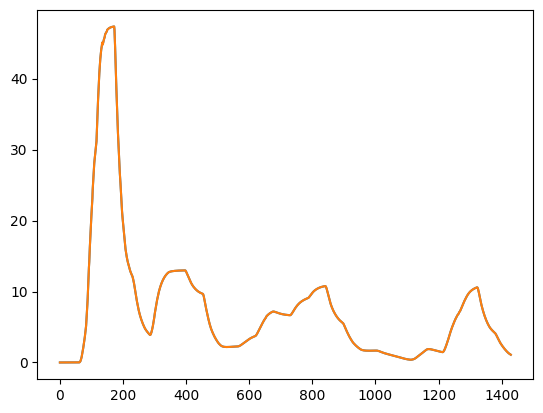

In [306]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

In [307]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,1].mean(axis=1))

In [327]:
edge_pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_pred.npy')
pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf))

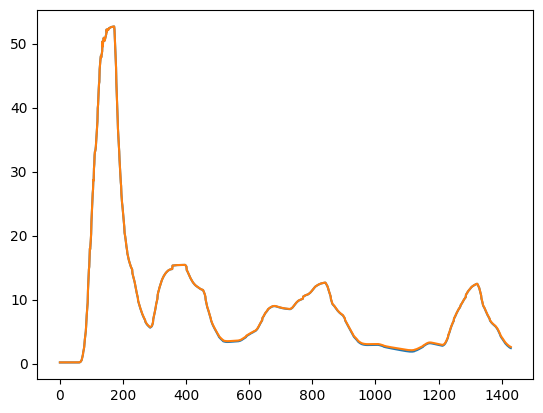

In [328]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

In [329]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,1].mean(axis=1))

## Train loss

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
cwd = './model/shunqing/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

In [5]:
train_ids

array([108,  55,   3,  43, 146,  19, 125,   3, 135,  58,   1,  71,  26,
        78, 130,  76,  54, 111, 123, 121,  99, 135, 141, 130,   5, 124,
         6,  25,  50, 127,   6,   2, 104,  77,  86, 141, 116,  18,  13,
        76,  91,  12, 123, 130,  19,  64,  72,  96,  77,  67,   3,  68,
        29,   7, 122,  76, 127,  14,  11,  55,  46,  91,  20, 124,  89,
        31,   7,  23,  80,   6,  46,  20,  69, 137,  77, 100,   5,  37,
         7,  22,  96,  79, 108,  90,  97,  38, 130, 133,  33, 118,  88,
       101,  79,  48, 142, 122,  84,  38,  98,  66, 132,  74,  18,  87,
        33,  38,  33,  26,   0,  41,  95,  68,  69,  58, 119,  53,  81,
       121])

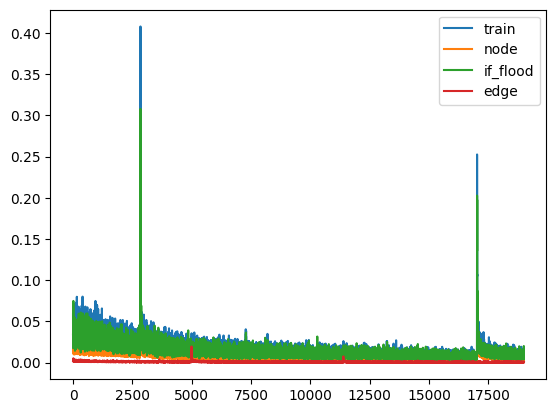

In [6]:
plt.plot(train_losses[1000:],label='train')
plt.plot(test_losses[1000:],label=['node','if_flood','edge'])
# plt.plot([sum(los) for los in test_losses[1000:]],label='test')
plt.legend()

# RedChicoSur

## Prediction

In [260]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [261]:
cwd = './results/RedChicoSur/5s_20k_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [262]:
from utilities import get_inp_files
from envs import get_env
env = get_env('RedChicoSur')()
train_id = np.load('./model/RedChicoSur/5s_20k_edge_res_norm_flood/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

['./envs/network/RedChicoSur/08_08_14.inp',
 './envs/network/RedChicoSur/eval_0.inp',
 './envs/network/RedChicoSur/train_0.inp',
 './envs/network/RedChicoSur/train_11.inp',
 './envs/network/RedChicoSur/train_17.inp',
 './envs/network/RedChicoSur/train_9.inp']

### Nodes

In [263]:
event = 'train_0'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred
err.shape

(342, 5, 443, 6)

In [264]:
inp = read_inp_file('./envs/network/RedChicoSur/'+event+'.inp')
gage = inp.RAINGAGES[env.config['rainfall']['gage']]
interval = int(gage.Interval.split(':')[0])*60 + int(gage.Interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
if gage.Format =='CUMULATIVE':
    rain = np.diff(rain)
rain_ind = [interval*idx for idx in range(len(rain))]

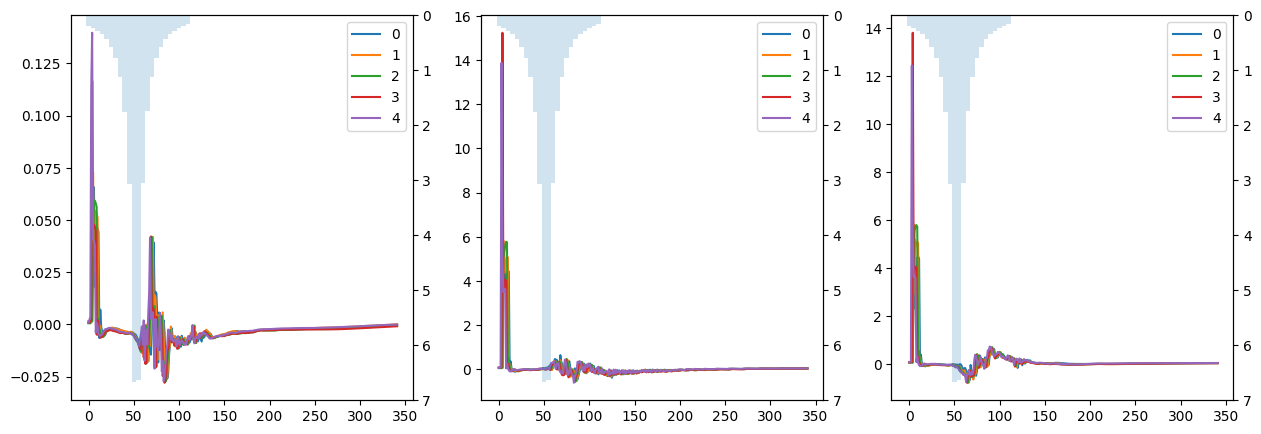

In [265]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(5):
        ax.plot(pred.mean(axis=2)[:,j,i]-true.mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=5,alpha=0.2)

In [266]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_ylabel(title)
    ax.set_xlabel('Time (min)')
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [268]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results


Water depth Total inflow Total outflow       Flooding
RMSE    0.002672    16.470682     18.493781       7.011409
MAE      0.00958     0.318667      0.340802       0.014634
R2      0.835574      0.79228      0.742047 -160794.922361

In [231]:
y_true = true[:,-1,:,-1][:,np.abs(true[:,-1,:,-1]).max(axis=0)>1e-6]
y_pred = pred[:,-1,:,-1][:,np.abs(true[:,-1,:,-1]).max(axis=0)>1e-6]
r2(y_true,y_pred,force_finite=False)

-372382.50516764284

In [192]:
y_true,y_pred

(array([2.11885936e+02, 3.25502215e+02, 7.29007945e+00, 5.90687479e-02,
        5.98859581e-03, 1.55934885e-02, 7.35864643e-01, 9.92419603e-03,
        1.13342178e-02, 8.35357866e-03, 1.30828800e-01, 1.97637071e-02,
        3.22254268e-02, 3.35480476e-02, 2.41705983e+00, 1.26648860e-02,
        7.47590406e-02, 1.73757234e-03, 2.98041677e-02, 8.59567256e-01,
        4.24708658e-02, 6.94502413e-02, 8.64882286e-03, 7.08534517e-01,
        5.69972525e-02, 2.92977014e-02, 1.41162748e-01, 6.38459498e-01,
        4.18886409e+00, 1.46106497e-01, 2.36358911e-02, 1.76817498e+00,
        3.16510547e-02, 1.24383501e+00, 3.61619702e-02, 3.49381450e-01,
        7.56080814e-01, 3.25421276e-02, 1.15983485e-01, 7.71014791e-02,
        1.20695003e-01, 1.91521611e+00, 1.17657985e+00, 1.19812657e-02,
        8.99075827e-03, 9.09030026e-01, 2.49473353e+00, 9.28694461e-03,
        2.06234970e-02, 1.56647552e+00, 7.40797153e-02, 3.34736692e+00,
        5.89636827e+00, 1.08723336e+00, 2.56461795e-02, 2.900914

In [200]:
y_true = true[:,-1,:,-1][true[:,-1,:,-1]>0]
y_pred = pred[:,-1,:,-1][true[:,-1,:,-1]>0]
r2(y_true,y_pred,force_finite=False)

-5.35662092290301

In [202]:
numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
numerator

980358.0722350598

In [193]:
denominator = (
        (y_true - np.average(y_true, axis=0)) ** 2
    ).sum(axis=0, dtype=np.float64)
denominator

154196.94128620284

In [270]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('DESC')

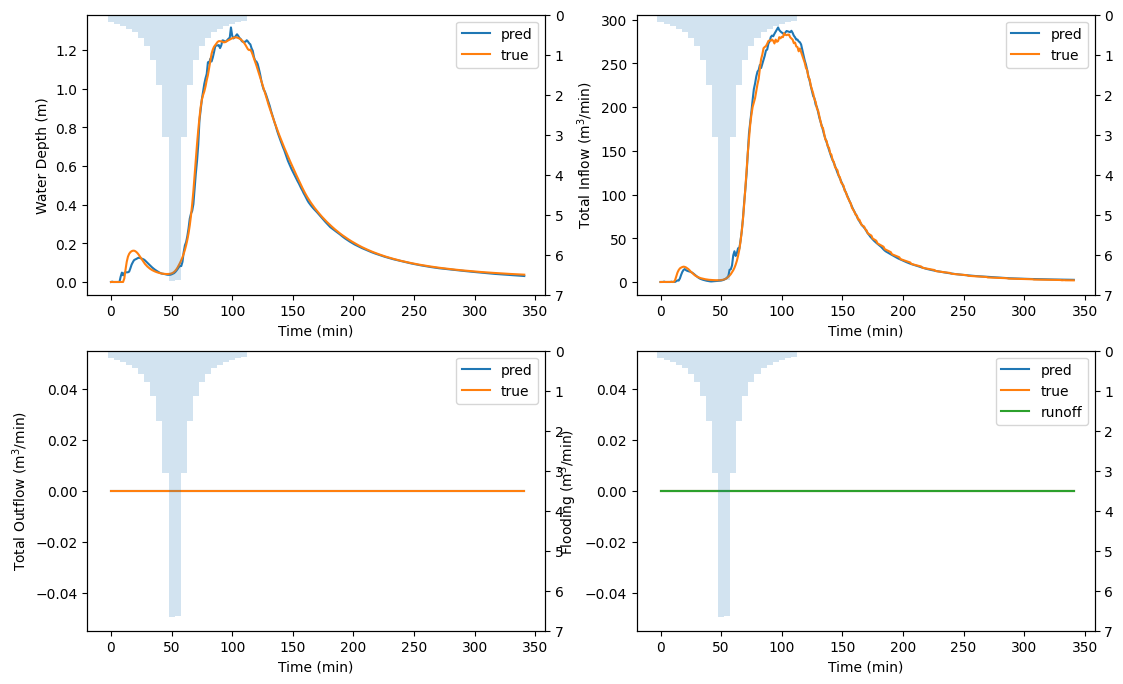

In [271]:
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(13,8))
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']

for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes) - 1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == - 1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    ax.legend()
    ax.set_ylabel(title)
    ax.set_xlabel('Time (min)')
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [272]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

Water depth Total inflow Total outflow Flooding
RMSE    0.000365     16.14926           0.0      0.0
MAE     0.012063     2.108117           0.0      0.0
R2      0.997822     0.998133           1.0      1.0

### Edge

In [282]:
event = 'train_0'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(342, 5, 444, 3)

In [283]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=5,alpha=0.2)

In [284]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

axes,titles = [ax1,ax2,ax3],['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']

for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
axx.set_ylabel('Rainfall (mm/5min)')

Text(0, 0.5, 'Rainfall (mm/5min)')

In [287]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3])
results.loc['R2','Link flow'] = r2(y_true[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3],y_pred[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3])
results

Link depth Link volume  Link flow
RMSE   0.000302    1.319606  16.602732
MAE    0.003858    0.168091   0.348012
R2     0.948623    0.905508   0.700236

In [279]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]
idx = links.index('PLT85829')


Text(0, 0.5, 'Rainfall (mm/5min)')

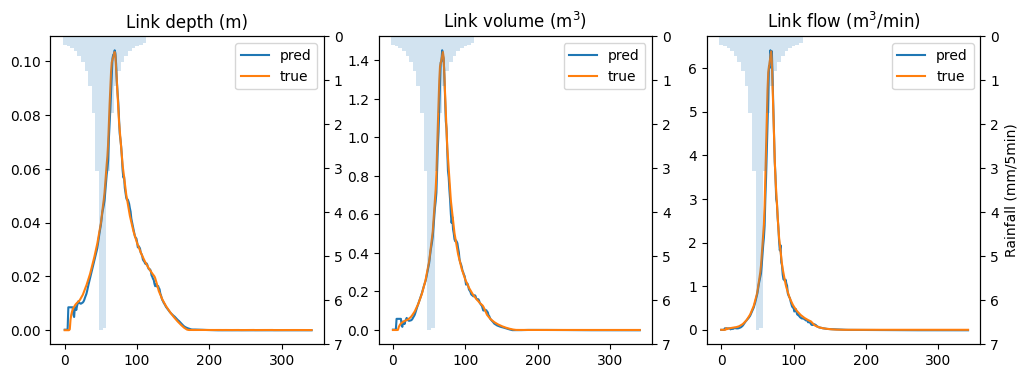

In [280]:
seq = 0

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

axes,titles = [ax1,ax2,ax3],['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']

for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
axx.set_ylabel('Rainfall (mm/5min)')

In [281]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results


Link depth Link volume Link flow
RMSE   0.000003     0.00044  0.009259
MAE    0.000811    0.009367  0.034699
R2     0.995166    0.994783  0.992968

## Debug

In [94]:
# debug node-edge balance loss
from envs import get_env
from numpy import matmul
event='train_0'
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))

env = get_env('RedChicoSur')()
env_args = env.get_args()
err = matmul(np.abs(env_args['node_edge']),edge_pred[...,-1:]) - pred[...,1:2] - pred[...,2:3]
for j in range(err.shape[1]):
    plt.plot(err.mean(axis=2)[:,j],label=j)
plt.legend()

## Training

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
cwd = './model/RedChicoSur/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

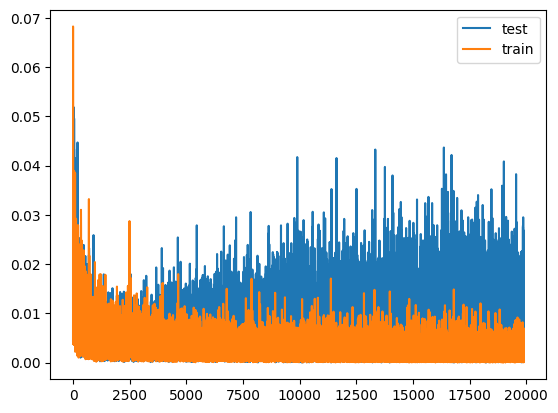

In [10]:
plt.plot(test_losses[100:].sum(axis=1),label='test')
plt.plot(train_losses[100:],label='train')
plt.legend()

# astlingen

## Prediction

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [20]:
# cwd = './results/astlingen/5s_edge_res_norm/'
cwd = './results/astlingen/30s_20k_edgef_res_norm_flood_gat_dat1s/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))
# event = 'astlingen_01_08_2002_19'
event = 'astlingen_02_28_2007_12'

In [24]:
inp = read_inp_file('./envs/network/astlingen/'+event+'.inp')
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

### Node

In [25]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

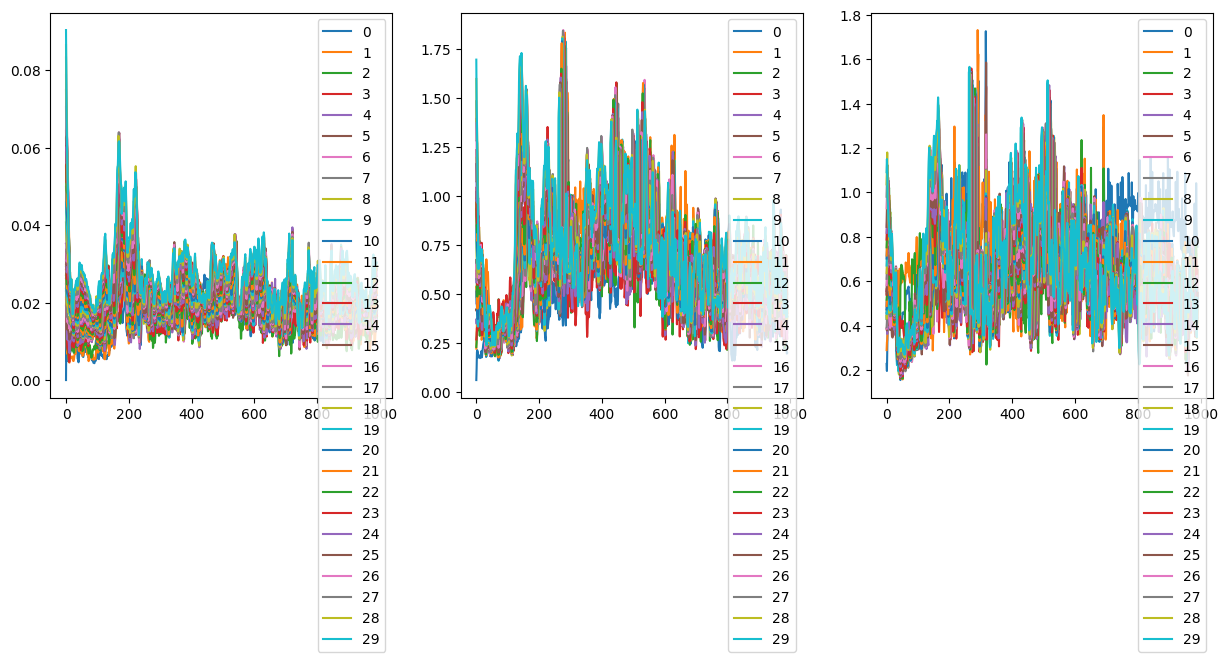

In [20]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

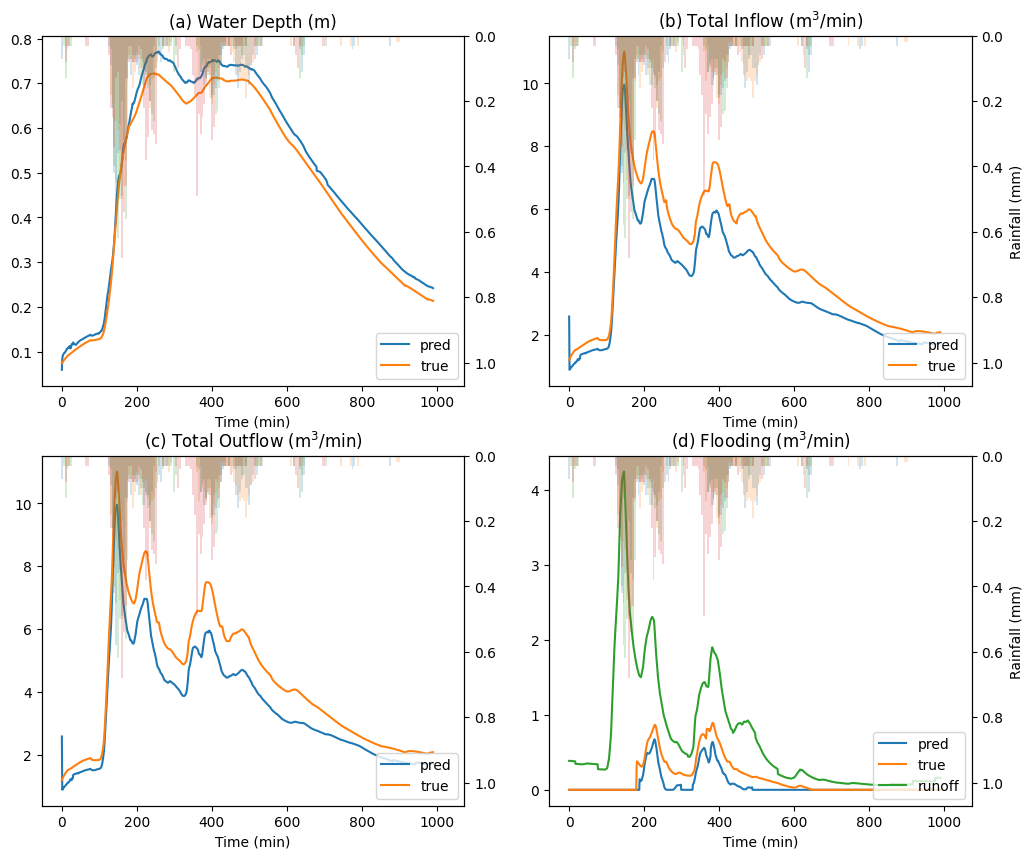

In [29]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
seq = -1

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)


In [30]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
# results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results


Water depth Total inflow Total outflow  Flooding
RMSE    0.004667     2.501681      2.357317  0.410302
MAE     0.031856     0.785214      0.859714  0.073094
R2      0.835986     0.580651      0.732299  0.981054

### Edge

In [31]:
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = edge_true - edge_pred
err.shape

(991, 30, 29, 3)

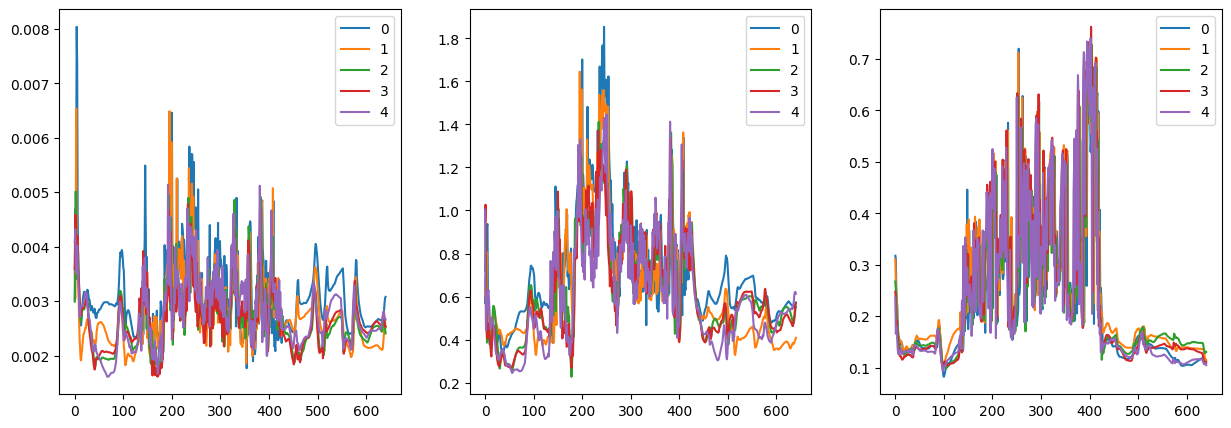

In [363]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0, 0.5, 'Rainfall (mm)')

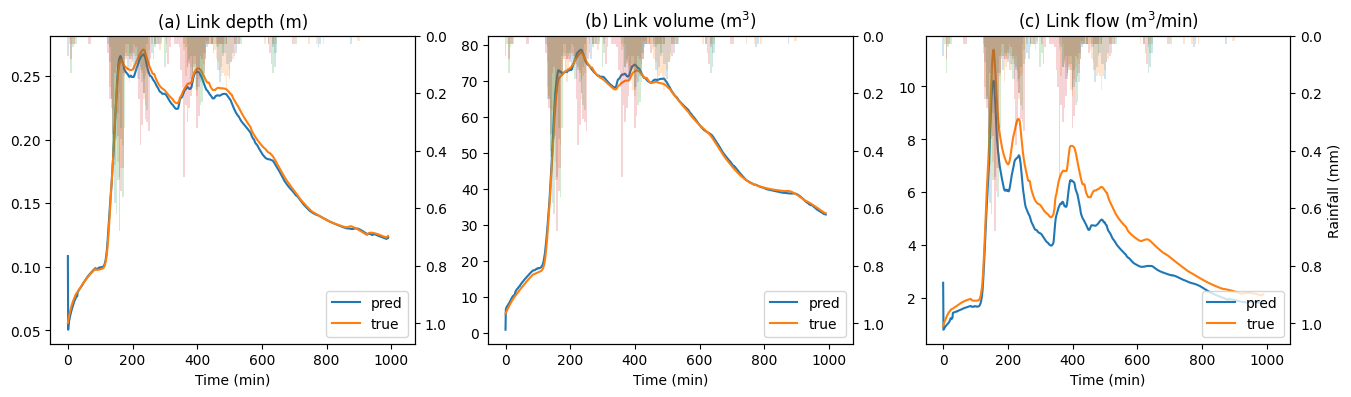

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
seq = 20

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')


In [365]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(edge_true,(-1,edge_true.shape[-2],edge_true.shape[-1]))
y_pred = np.reshape(edge_pred,(-1,edge_pred.shape[-2],edge_pred.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3])
results.loc['R2','Link flow'] = r2(y_true[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3],y_pred[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3])
results

Link depth Link volume Link flow
RMSE    0.00002     2.00314  0.244346
MAE    0.002788       0.639  0.238171
R2     0.982037    0.993096  0.965023

In [353]:
y_true.shape

(6370, 29, 3)

### Element-level

In [11]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/astlingen/astlingen.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)+list(inp.STORAGE)]
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]

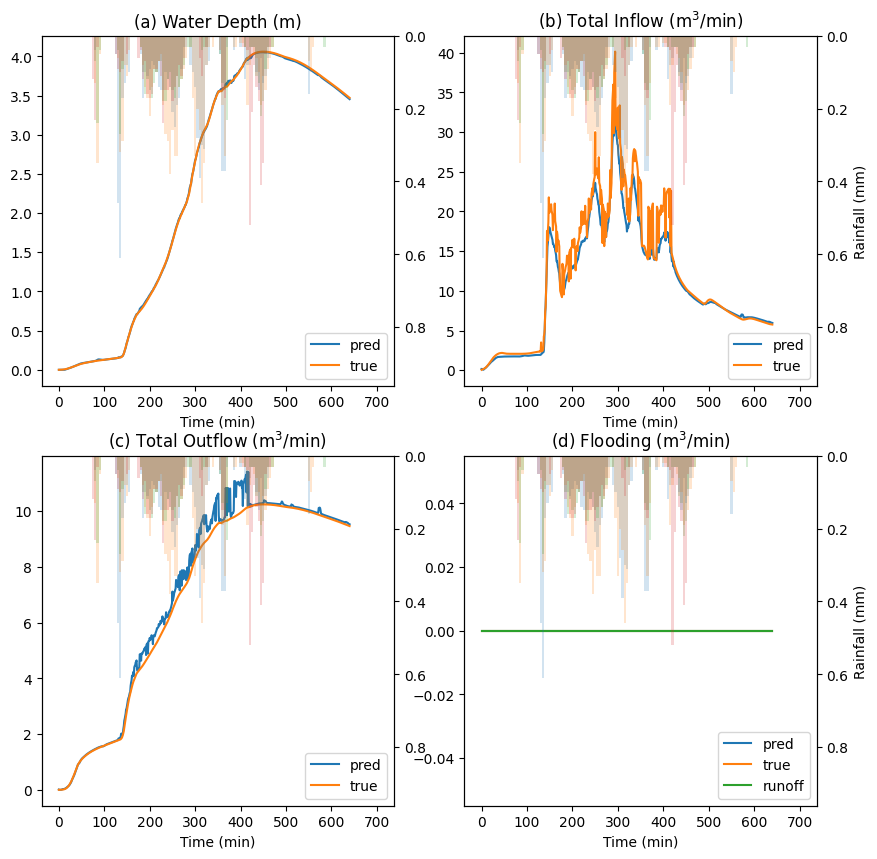

In [14]:
idx = nodes.index('T3')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes) - 1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == -1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    axylim = ax.get_ylim()
    # if max([abs(lim) for lim in axylim]) < 0.1:
    #     ax.set_ylim(axylim[0]*100,axylim[1]*100)
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[i]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if i in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
    

In [326]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],pred.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

Water depth Total inflow Total outflow Flooding
RMSE    0.004349    17.499983      0.127656      0.0
MAE     0.052139      3.06321      0.236787      0.0
R2      0.998411      0.75726      0.991065      1.0

Text(0, 0.5, 'Rainfall (mm)')

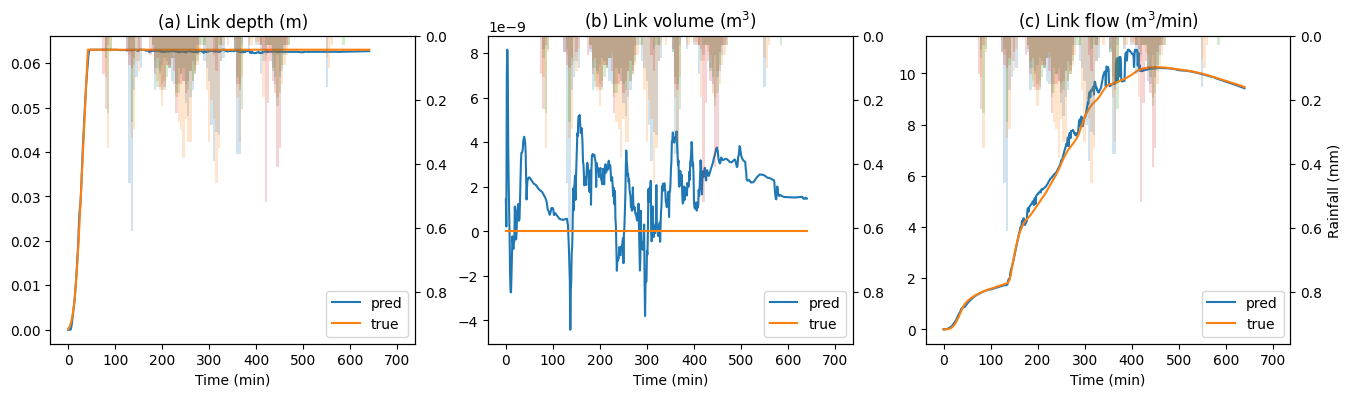

In [367]:
seq = -1
idx = links.index('V3')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_pred[:,seq,idx,i],label='pred')
    ax.plot(edge_true[:,seq,idx,i],label='true')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[i]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')

In [368]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(edge_true,(-1,edge_true.shape[-2],edge_true.shape[-1]))
y_pred = np.reshape(edge_pred,(-1,edge_pred.shape[-2],edge_pred.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results

Link depth Link volume Link flow
RMSE        0.0         0.0  0.082141
MAE    0.000373         0.0  0.172401
R2     0.998398         0.0  0.993798

### Flooding comparison

In [56]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_pred.npy'))

FileNotFoundError: [Errno 2] No such file or directory: './results/astlingen/5s_edge_res_norm_flood/astlingen_01_08_2002_19_pred.npy'

### Debug

In [110]:
from envs import get_env
env = get_env('astlingen')()
env_args = env.get_args()
node_edge = env_args['node_edge']

In [120]:
edge_true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_true.npy')
true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

In [121]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

In [115]:
edge_pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_pred.npy')
pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_pred[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_pred[...,-1:],-np.inf,0))

In [116]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

In [134]:
env.get_features('links')

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6']

### Rainfalls

In [127]:
import pandas as pd
rain = pd.read_csv('./envs/config/ast_rain_events.csv',index_col=0)
rain = rain[rain['Precipitation'].apply(lambda x:5<x<15)]
train = rain[rain['Date'].apply(lambda x:eval(x[-1])<7)]
test = rain[rain['Date'].apply(lambda x:eval(x[-1])>6)]
train.to_csv('./envs/config/ast_train_events.csv')
test.to_csv('./envs/config/ast_test_events.csv')

### Conv-nn compare

In [25]:
event = 'astlingen_08_22_2007_21'
inp = read_inp_file('./envs/network/astlingen/'+event+'.inp')
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

In [50]:
cwd = './results/astlingen/30s_20k_1000l_edgef_res_norm_flood_nn/'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('nn','gat').replace('_1000l',''),event+'_pred.npy'))

In [51]:
true.shape,pred.shape,fpred.shape

((201, 30, 30, 6), (201, 30, 30, 6), (201, 30, 30, 6))

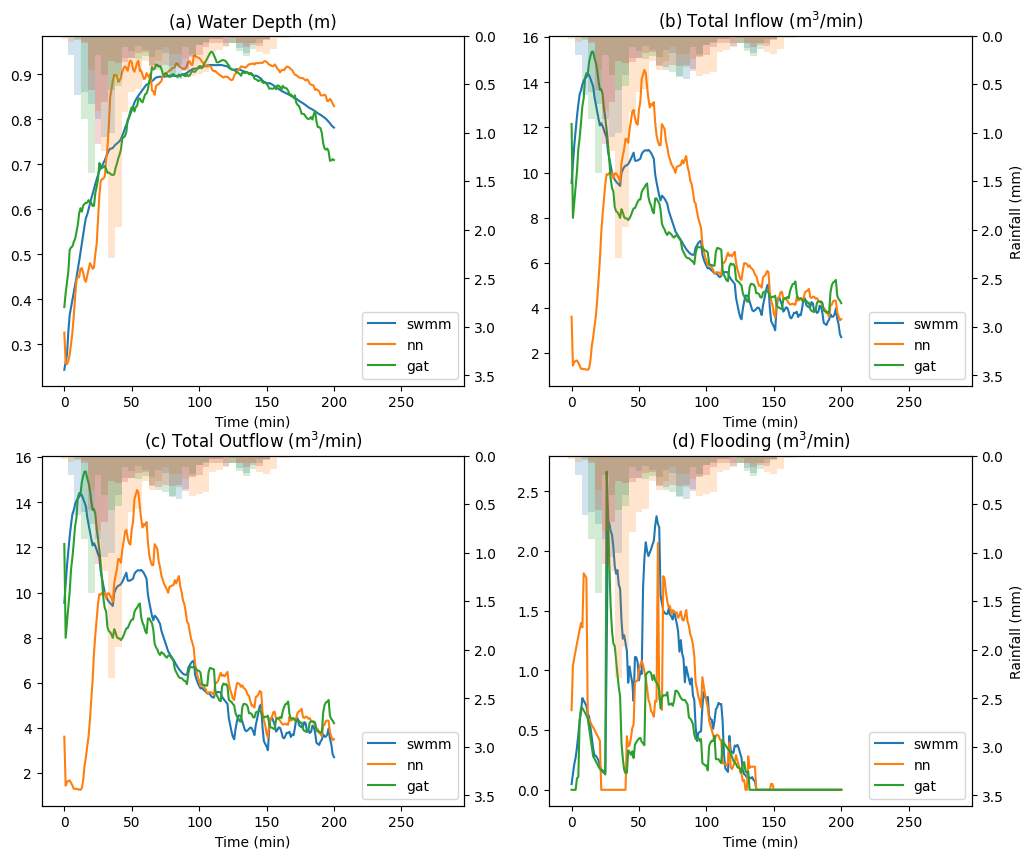

In [52]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
seq = -1

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='swmm')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='nn')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='gat')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)

In [53]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(true,(0,2,1,3)),(-1,true.shape[1],true.shape[-1]))
y_pred = np.reshape(np.transpose(pred,(0,2,1,3)),(-1,pred.shape[1],pred.shape[-1]))
y_fpred = np.reshape(np.transpose(fpred,(0,2,1,3)),(-1,fpred.shape[1],fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(fpred2,(0,2,1,3)),(-1,fpred2.shape[1],fpred2.shape[-1]))
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Water depth    0.079194  0.073933  0.066278  0.062113
Total inflow   2.282000  1.782416  1.926402  1.466410
Total outflow  2.408479  1.979347  2.031588  1.624766
Flooding       0.449527  0.331306  0.311928  0.256507

In [54]:
cwd = './results/astlingen/30s_20k_1000l_edgef_res_norm_flood_nn/'
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('nn','gat').replace('_1000l',''),event+'_edge_pred.npy'))
err = edge_true - edge_pred
err.shape

(201, 30, 29, 3)

Text(0, 0.5, 'Rainfall (mm)')

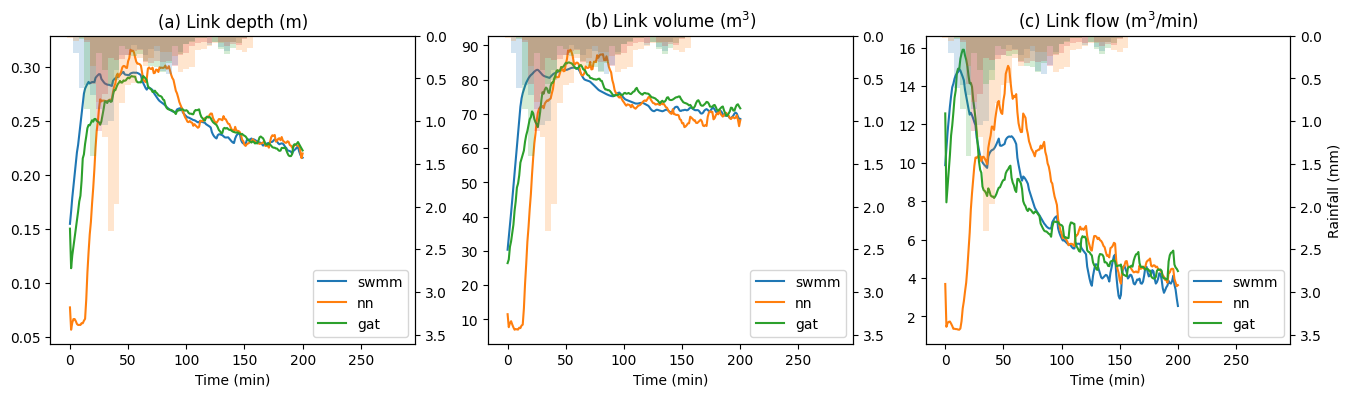

In [55]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
seq = -1

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='swmm')
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='nn')
    ax.plot(edge_fpred[:,seq,...].mean(axis=1)[:,idx],label='gat')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')


In [57]:
columns = ['Link depth','Link volume','Link flow']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(edge_true,(0,2,1,3)),(-1,edge_true.shape[1],edge_true.shape[-1]))
y_pred = np.reshape(np.transpose(edge_pred,(0,2,1,3)),(-1,edge_pred.shape[1],edge_pred.shape[-1]))
y_fpred = np.reshape(np.transpose(edge_fpred,(0,2,1,3)),(-1,edge_fpred.shape[1],edge_fpred.shape[-1]))
# y_fpred2 = np.reshape(np.transpose(fpred2,(0,2,1,3)),(-1,fpred2.shape[1],fpred2.shape[-1]))
for i in [0,1,2]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE_nn'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred[...,i].T,squared=False)
    # results.loc[columns[i],'RMSE_gat'] = mse(y_true[...,i].T,y_fpred2[...,i].T,squared=False)
    results.loc[columns[i],'MAE_nn'] = mae(y_true[...,i].T,y_pred[...,i].T)
    results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred[...,i].T)
    # results.loc[columns[i],'MAE_gat'] = mae(y_true[...,i].T,y_fpred2[...,i].T)
    # results.loc['R2',columns[i]] = r2(y_true[...,i].T,y_pred[...,i].T)
results

RMSE_nn  RMSE_gat    MAE_nn   MAE_gat
Link depth   0.027897  0.019866  0.023352  0.016660
Link volume  8.497134  5.935989  7.146940  5.148563
Link flow    2.489673  2.052957  2.103111  1.686936

## Train loss

In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [34]:
train_losses = np.load('./model/astlingen/60s_20k_act_edgef_res_norm_flood_gat/train_loss.npy')
test_losses = np.load('./model/astlingen/60s_20k_act_edgef_res_norm_flood_gat/test_loss.npy')
plt.plot([min(los,0.1) for los in train_losses[500:]])
plt.plot([min(los[1],0.1) for los in test_losses[500:]])

In [38]:
plt.plot([[los[1],los[0],los[2]] for los in test_losses[2500:]],label=['flood','node','edge'])
# plt.plot([[los[0],los[2]] for los in test_losses[2500:]],label=['node','edge'])
plt.legend()

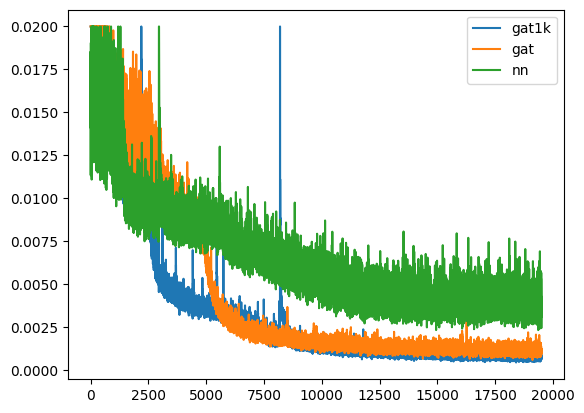

In [117]:
gat1000_test = np.load('./model/astlingen/30s_20k_1000l_edgef_res_norm_flood_gat/test_loss.npy')
gat_test = np.load('./model/astlingen/30s_20k_edgef_res_norm_flood_gat/test_loss.npy')
nn_test = np.load('./model/astlingen/30s_20k_1000l_edgef_res_norm_flood_nn/test_loss.npy')
plt.plot([min(los[2],0.02) for los in gat1000_test[500:]],label='gat1k')
plt.plot([min(los[2],0.02) for los in gat_test[500:]],label='gat')
plt.plot([min(los[2],0.02) for los in nn_test[500:]],label='nn')
plt.legend()

## MPC Test

In [1]:
from emulator import Emulator
from envs import astlingen
import yaml,argparse,os,time
import numpy as np
import multiprocessing as mp
from mpc import get_runoff
from utilities import get_inp_files
from swmm_api import read_inp_file
import matplotlib.pyplot as plt

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prediction validation

In [2]:
cwd = '60s_20k_act_edgef_res_norm_flood_gat_depth'
result_dir = '60s_20k_act_edgef_res_norm_flood_gat_depth'
hyps = yaml.load(open('config.yaml','r'),yaml.FullLoader)
args = argparse.Namespace(**hyps['astlingen'])
args.model_dir = os.path.join(args.model_dir,cwd)
args.result_dir = os.path.join(args.result_dir,result_dir)
known_hyps = yaml.load(open(os.path.join(args.model_dir,'parser.yaml'),'r'),yaml.FullLoader)
env = astlingen()
env_args = env.get_args()
for k,v in list(known_hyps.items())+list(env_args.items()):
    if k == 'model_dir':
        continue
    setattr(args,k,v)
args.use_edge = args.use_edge or args.edge_fusion
args.n_step,args.r_step = args.prediction['control_horizon']//args.setting_duration,args.setting_duration//args.interval
emul = Emulator(args.conv,args.resnet,args.recurrent,args)
emul.load(os.path.join(args.model_dir,'test'))
# emul.load(args.model_dir)

if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)

In [17]:
env.config['rainfall']

{'func': 'generate_split_file',
 'filedir': './envs/network/astlingen/astlingen',
 'rainfall_timeseries': './envs/config/ast_rain.csv',
 'rainfall_events': './envs/config/ast_train_events.csv',
 'MIET': 120,
 'duration_range': [60, 100000],
 'precipitation_range': [5, 15],
 'date_range': ['01/01/2000', '12/31/2009'],
 'replace_rain': False,
 'tide': False}

In [239]:
rain_arg = env.config['rainfall']
# rain_arg['rainfall_events'] = './envs/config/ast_test5_events.csv'
event = get_inp_files(env.config['swmm_input'],rain_arg)[0]
name = os.path.basename(event).strip('.inp')
_,runoff = get_runoff(env,event,rate=False)
horizon = args.prediction['eval_horizon']//args.interval
runoff = np.stack([np.concatenate([runoff[idx:idx+horizon],np.tile(np.zeros_like(s),(max(idx+horizon-runoff.shape[0],0),)+tuple(1 for _ in s.shape))],axis=0)
                    for idx,s in enumerate(runoff)])

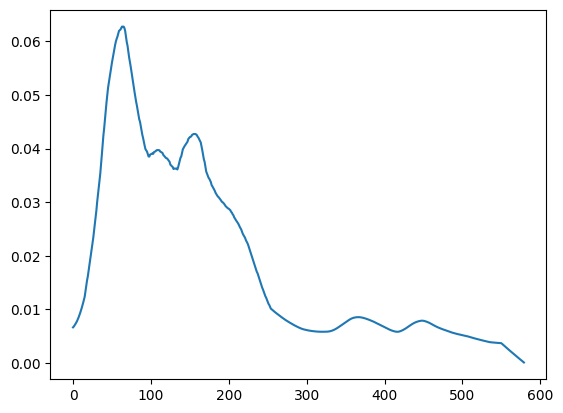

In [8]:
# Cumulative lateral flow result
plt.plot(runoff[...,-1].mean(axis=-1).mean(axis=-1)/60)

In [76]:
# Lateral flow rate result
plt.plot(runoff[...,-1].mean(axis=-1).mean(axis=-1))

### Rolling prediction for MPC (60 mins with seq_out)

In [7]:
state = env.reset(event,global_state=True,seq=args.seq_in)
perf = env.flood(seq=args.seq_in)
states,perfs = [state[-1]],[perf[-1]]
edge_state = env.state_full(typ='links',seq=args.seq_in)
edge_states = [edge_state[-1]]
setting = [1 for _ in env.config['action_space']]
settings = [setting]
preds = []
done,i = False,0
while not done:
    if i*args.interval % args.prediction['control_horizon'] == 0:
        j = 0
        setting = np.array([[env.controller(mode='bc')
         for _ in range(args.n_step)]])
        setting = np.concatenate([np.repeat(setting[:,i:i+1,:],args.r_step,axis=1)
                                   for i in range(setting.shape[1])],axis=1)
        if setting.shape[1] < args.prediction['eval_horizon']:
            setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon']-setting.shape[1],axis=1)],axis=1)
        if args.if_flood:
            f = (perf>0).astype(int)
            f = np.eye(2)[f].squeeze(-2)
            state = np.concatenate([state,f],axis=-1)

        state = np.expand_dims(state,0)
        r = np.expand_dims(runoff[i],0)
        edge_state = np.expand_dims(edge_state,0)
        pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
        preds.append(pred)

    done = env.step(setting[0,j,:])
    state = env.state(seq=args.seq_in)
    perf = env.flood(seq=args.seq_in)
    edge_state = env.state_full(args.seq_in,'links')
    states.append(state[-1])
    perfs.append(perf[-1])
    edge_states.append(edge_state[-1])
    settings.append(setting[0,j,:])
    i += 1
    j += 1
states,perfs,edge_states,settings = [np.stack(dat,axis=0) for dat in [states,perfs,edge_states,settings]]
if args.use_edge:
    preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
else:
    preds = np.concatenate(preds,axis=1)

In [5]:
states.shape,perfs.shape,preds.shape

((581, 30, 4), (581, 30, 1), (600, 30, 6))

In [7]:
runoff.shape

(580, 60, 30, 1)

In [8]:
inp = read_inp_file(event)
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

In [50]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
        ax.plot(perfs[1:,:,0].mean(axis=1),label='true')
    else:
        ax.plot(states[1:,:,idx].mean(axis=1),label='true')
    ax.plot(preds[...,idx].mean(axis=1),label='pred')
    if idx == -1:
        ax.plot(runoff[:,0,...,0].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)

In [14]:
edge_states.shape,edge_preds.shape

((581, 29, 4), (600, 29, 3))

Text(0, 0.5, 'Rainfall (mm)')

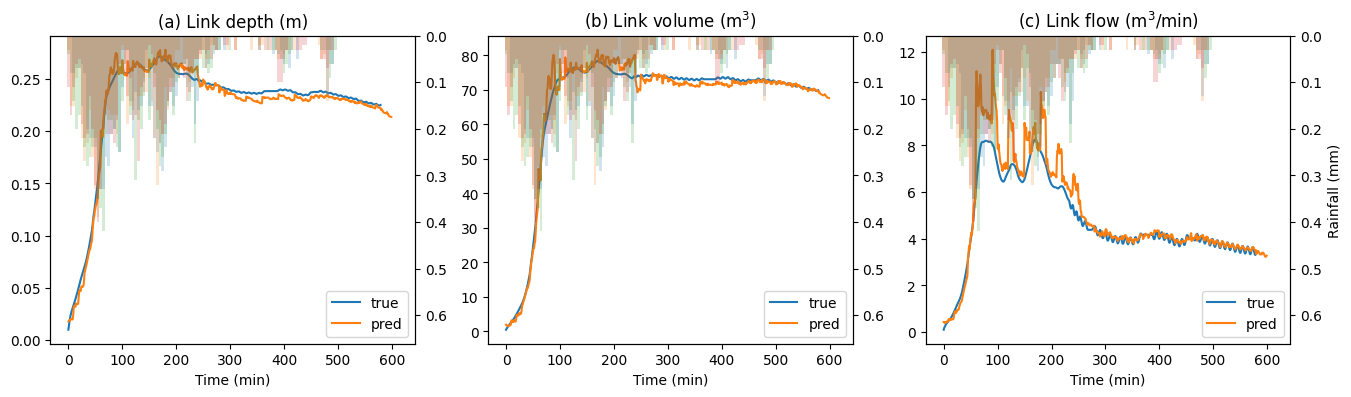

In [51]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_states[1:,:,idx].mean(axis=1),label='true')
    ax.plot(edge_preds[...,idx].mean(axis=1),label='pred')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')

### Predictive evaluation results comparison between SWMM-hsf and surrogate of random actions

TODO: Emulation vs Simulation of random control actions in each time step

In [240]:
from mpc import pred_simu

- Need a subprocess for predictive simulation to avoid distraction
- Multiprocessing doesn't work in jupyter --> define the function in another file

In [241]:
pop_size = 256
# y = np.array([[[1.0,1.0,1.0,1.0]
y = np.array([[env.controller(mode='rand')
for _ in range(args.n_step)] for _ in range(pop_size)])
setting = np.concatenate([np.repeat(y[:,i:i+1,:],args.r_step,axis=1)
                        for i in range(y.shape[1])],axis=1)
if setting.shape[1] < args.prediction['eval_horizon'] // args.interval:
    setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon'] // args.interval - setting.shape[1],axis=1)],axis=1)

In [242]:
if __name__ == '__main__':
    idx = 7
    state = env.reset(event,global_state=True,seq=args.seq_in)
    perf = env.flood(seq=args.seq_in)
    edge_state = env.state_full(typ='links',seq=args.seq_in)
    # preds,simu_preds = [],[]
    done,i,j = False,0,args.prediction['control_horizon']//args.interval


    while not done:
        # if i*args.interval % args.prediction['control_horizon'] == 0:
        if i == 8 * args.prediction['control_horizon']:
            j,perfs,states,edge_states = 0,[],[],[]
            rrs = []
            if args.if_flood:
                f = (perf>0).astype(int)
                f = np.eye(2)[f].squeeze(-2)
                state = np.concatenate([state[...,:-1],f,state[...,-1:]],axis=-1)
            state = np.repeat(np.expand_dims(state,0),pop_size,axis=0)
            r = np.repeat(np.expand_dims(runoff[i],0),pop_size,axis=0)
            edge_state = np.repeat(np.expand_dims(edge_state,0),pop_size,axis=0)
            t0 = time.time()
            pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
            t1 = time.time()
            print('emulation time: %s'%(t1-t0))
            # preds.append(pred)

            eval_file = env.get_eval_file(args.prediction['no_runoff'])
            pool = mp.Pool(args.processes)
            res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0]/args.interval/60,)) for yi,ri in zip(y,r)]
            # res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0],)) for yi,ri in zip(y,r)]
            pool.close()
            pool.join()
            F = [r.get() for r in res]        
            simu_pred = np.stack(F)
            print('hsf simu time: %s'%(time.time()-t1))
            # simu_pred = np.stack([pred_simu(sett,eval_file,args) for sett in setting])
            # simu_preds.append(simu_pred)

        if j < args.prediction['control_horizon']:
            done = env.step(setting[idx,j,:])
            state = env.state()
            states.append(state)
            edge_state = env.state_full(typ='links')
            edge_states.append(edge_state)
            rr = [env.env._getNodeLateralInflow(node) for node in env.elements['nodes']]
            rrs.append(rr)
            perf = env.flood()
            perfs.append(perf)
            j += 1
        else:
            done = env.step()
        state = env.state(seq=args.seq_in)
        perf = env.flood(seq=args.seq_in)
        edge_state = env.state_full(args.seq_in,'links')
        # states.append(state[-1])
        # perfs.append(perf[-1])
        # edge_states.append(edge_state[-1])
        i += 1
        # print('Simulation time: %s'%env.data_log['simulation_time'][-1])
    # states,perfs,edge_states = [np.stack(dat,axis=0) for dat in [states,perfs,edge_states]]
    # if args.use_edge:
    #     preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
    # else:
    #     preds = np.concatenate(preds,axis=1)


emulation time: 61.64907383918762
hsf simu time: 199.5802402496338


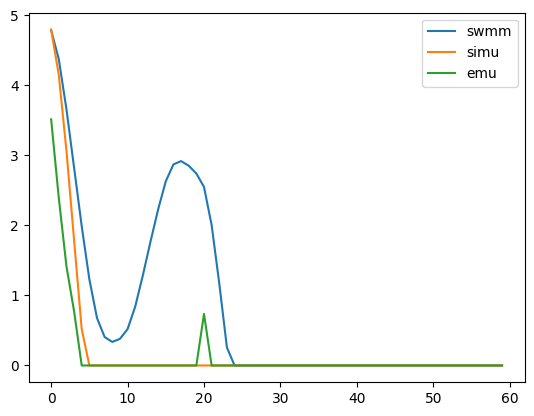

In [243]:
perfs = np.stack(perfs)
emu_perf,simu_perf = pred[0][idx,...,-1],simu_pred[idx,...,0]
plt.plot(perfs[...,0].sum(axis=-1),label='swmm')
plt.plot(simu_perf.sum(axis=-1),label='simu')
plt.plot(emu_perf.sum(axis=-1),label='emu')
plt.legend()

In [46]:
r.shape

(256, 60, 30, 1)

In [22]:
emu_perf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

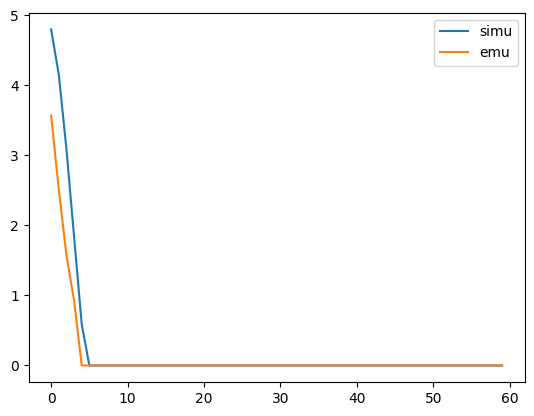

In [140]:
# perfs = np.stack(perfs)
iidx = 9
emu_perf,simu_perf = pred[0][iidx,...,-1],simu_pred[iidx,...,0]
# plt.plot(perfs[...,0].sum(axis=-1),label='swmm')
plt.plot(simu_perf.sum(axis=-1),label='simu')
plt.plot(emu_perf.sum(axis=-1),label='emu')
plt.legend()

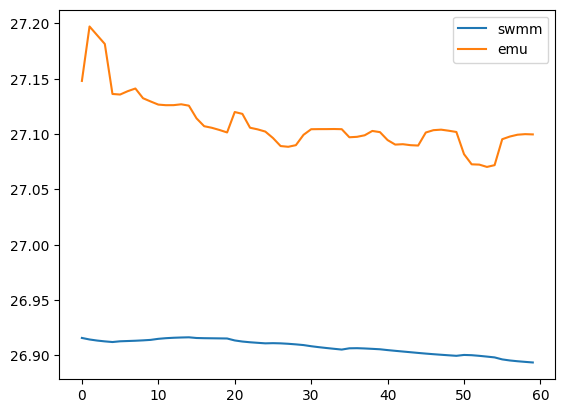

In [244]:
states = np.stack(states)
plt.plot(states[...,0].mean(axis=-1),label='swmm')
plt.plot(pred[0][idx,...,0].mean(axis=-1),label='emu')
plt.legend()

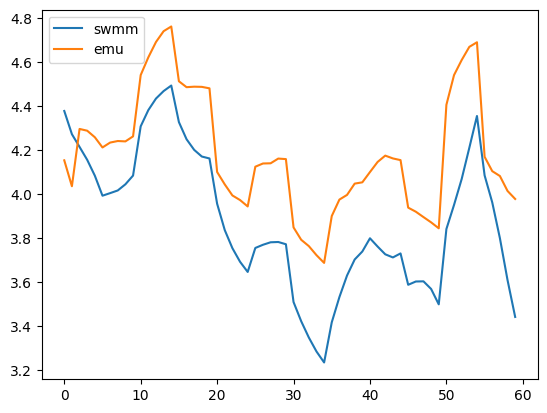

In [245]:
edge_states = np.stack(edge_states)
plt.plot(edge_states[...,2].mean(axis=-1),label='swmm')
plt.plot(pred[1][idx,...,2].mean(axis=-1),label='emu')
plt.legend()

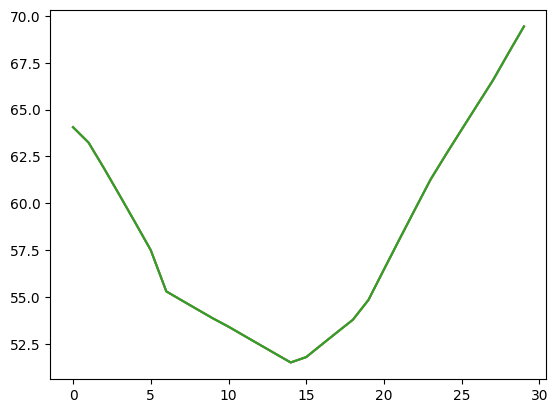

In [71]:
plt.plot(r[0,...,0].sum(axis=-1))
states = np.stack(states)
plt.plot(states[...,-1].sum(axis=-1))
rrs = np.stack(rrs)
plt.plot(rrs.sum(axis=-1))

There are bugs in hotstart files. Maybe the save_hotstart function needs to be fixed for only hydraulic stuff, and lateral inflow show be imported through generate_inflow.

In [11]:
if __name__ == '__main__':
    pop_size = 64
    state = env.reset(event,global_state=True,seq=args.seq_in)
    perf = env.flood(seq=args.seq_in)
    edge_state = env.state_full(typ='links',seq=args.seq_in)
    perfs,preds,simu_preds = [],[],[]
    done,i,j = False,0,30

    y = np.array([[env.controller(mode='rand')
    for _ in range(args.n_step)] for _ in range(pop_size)])
    setting = np.concatenate([np.repeat(y[:,i:i+1,:],args.r_step,axis=1)
                            for i in range(y.shape[1])],axis=1)
    if setting.shape[1] < args.prediction['eval_horizon'] // args.interval:
        setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon'] // args.interval - setting.shape[1],axis=1)],axis=1)
    
    while not done:
        if i*args.interval % args.prediction['control_horizon'] == 0:
            if args.if_flood:
                f = (perf>0).astype(int)
                f = np.eye(2)[f].squeeze(-2)
                state = np.concatenate([state[...,:-1],f,state[...,-1:]],axis=-1)
            state = np.repeat(np.expand_dims(state,0),pop_size,axis=0)
            r = np.repeat(np.expand_dims(runoff[i],0),pop_size,axis=0)
            edge_state = np.repeat(np.expand_dims(edge_state,0),pop_size,axis=0)
            pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
            preds.append(pred[0][...,-1:])

            eval_file = env.get_eval_file(args.prediction['no_runoff'])
            pool = mp.Pool(args.processes)
            res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0]/args.interval/60,)) for yi,ri in zip(y,r)]
            # res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0],)) for yi,ri in zip(y,r)]
            pool.close()
            pool.join()
            F = [r.get() for r in res]        
            simu_pred = np.stack(F)
            # simu_pred = np.stack([pred_simu(sett,eval_file,args) for sett in setting])
            simu_preds.append(simu_pred)

        done = env.step()
        state = env.state(seq=args.seq_in)
        perf = env.flood(seq=args.seq_in)
        edge_state = env.state_full(args.seq_in,'links')
        # states.append(state[-1])
        perfs.append(perf[-1])
        # edge_states.append(edge_state[-1])
        i += 1
        # print('Simulation time: %s'%env.data_log['simulation_time'][-1])
    perfs = np.stack(perfs,axis=0)
    # if args.use_edge:
    #     preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
    # else:
    #     preds = np.concatenate(preds,axis=1)

In [12]:
simu_perf = np.squeeze(np.stack([pred for pred in simu_preds if pred.shape[1] == args.prediction['eval_horizon']]))
emu_perf = np.squeeze(np.stack(preds[:simu_perf.shape[0]]))
emu_perf.shape

(19, 64, 30, 30)

In [13]:
idx = 7
simu,emu = simu_perf[idx,...].sum(axis=-1).sum(axis=-1),emu_perf[idx,...].sum(axis=-1).sum(axis=-1)
plt.scatter(simu,emu)
# ly = lx =np.arange(min(simu.min(),emu.min()),max(simu.max(),emu.max()),10)
# plt.plot(lx,ly,'x--')
plt.xlabel('simu')
plt.ylabel('emu')

Text(0, 0.5, 'emu')

### Generate inflow test

Modify the hotstart function for hydraulic predictive modelling, use external hydrological inflow instead of SWMM.

In [31]:
from utilities import get_inp_files
import numpy as np
from envs import astlingen

In [32]:
event = get_inp_files(env.config['swmm_input'],env.config['rainfall'])[0]
env = astlingen(swmm_file = event)
done = False
clis,lis = [],[]
nodes = env.get_features('nodes')
while not done:
    lis.append([env.env._getNodeLateralInflow(n) for n in nodes])
    clis.append([env.env._getNodeLateralInflowVol(n) for n in nodes])
    done = env.step()
lis,clis = np.array(lis),np.array(clis)

In [38]:
import matplotlib.pyplot as plt
plt.plot(lis.mean(axis=1))
plt.plot(np.diff(clis,axis=0).mean(axis=1)/60)

In [64]:
r.max()/60

0.028940908314719613

In [31]:
from swmm_api import read_inp_file
inp = read_inp_file(event)

In [32]:
inp.pop('DWF')
inp.write_file('test.inp')

'test.inp'

### Performance

In [40]:
env = astlingen()
name = 'astlingen_08_22_2007_21'
event = './envs/network/astlingen/%s.inp'%name
inp = read_inp_file(event)
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

In [44]:
cwd = './results/astlingen/30s_10k_mpc_edgef_resn_norm_flood/'
e_perf = np.load(os.path.join(cwd,name+'_emul_perf.npy'))
s_perf = np.load(os.path.join(cwd,name+'_simu_perf.npy'))
e_perf.shape

(266, 30, 1)

In [73]:
fig,ax = plt.subplots(1,1,figsize=(7,3))

ax.plot(e_perf.sum(axis=1)[:,0],label='surrogate')
ax.plot(s_perf.sum(axis=1)[:,0],label='SWMM')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Flooding (L/min)')
axx = ax.twinx()
axx.invert_yaxis()
for j,rain in enumerate(rains):
    axx.bar(rain_ind,rain,width=4,alpha=0.2,label='rain%s'%(j+1))
ax.legend()
axx.set_ylabel('Rainfall (mm)')
# axx.set_ylim(axx.get_ylim()[0]*1.5,0)

Text(0, 0.5, 'Rainfall (mm)')

Text(0, 0.5, 'Rainfall (mm)')

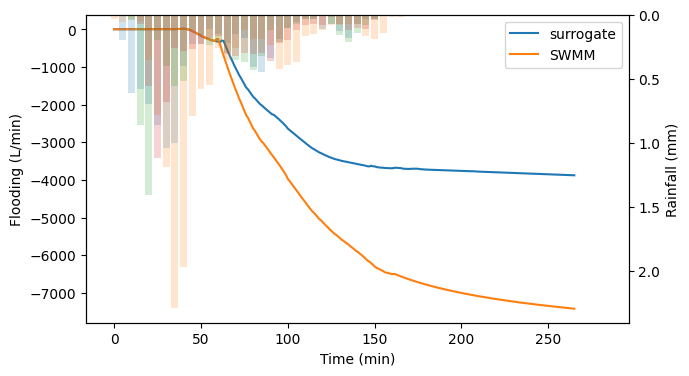

In [72]:
e_object = np.load(os.path.join(cwd,name+'_emul_object.npy'))
s_object = np.load(os.path.join(cwd,name+'_simu_object.npy'))
fig,ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(e_object[:,0],label='surrogate')
ax.plot(s_object[:,0],label='SWMM')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Flooding (L/min)')
axx = ax.twinx()
axx.invert_yaxis()
for j,rain in enumerate(rains):
    axx.bar(rain_ind,rain,width=4,alpha=0.2,label='rain%s'%(j+1))
ax.legend()
axx.set_ylabel('Rainfall (mm)')

In [57]:
e_set = np.load(os.path.join(cwd,name+'_emul_settings.npy'))
s_set = np.load(os.path.join(cwd,name+'_simu_settings.npy'))
e_set.shape

(266, 4)

Text(0, 0.5, 'Rainfall (mm)')

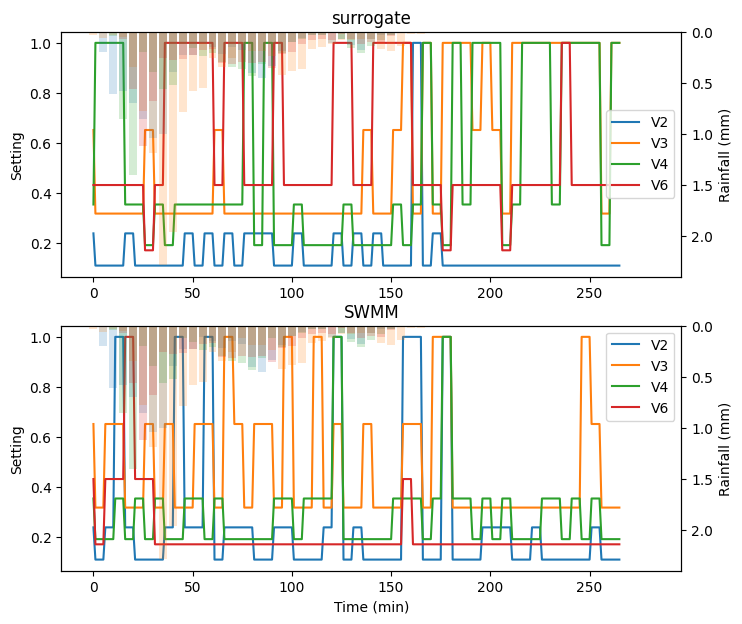

In [70]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,7))

for i,(ori,sett) in zip(range(e_set.shape[1]),env.config['action_space'].items()):
    ax1.plot([sett[st] for st in e_set[:,i]],label=ori)
ax1.set_title('surrogate')
# ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Setting')
axx = ax1.twinx()
axx.invert_yaxis()
for j,rain in enumerate(rains):
    axx.bar(rain_ind,rain,width=4,alpha=0.2,label='rain%s'%(j+1))
ax1.legend()
axx.set_ylabel('Rainfall (mm)')

for i,(ori,sett) in zip(range(s_set.shape[1]),env.config['action_space'].items()):
    ax2.plot([sett[st] for st in s_set[:,i]],label=ori)
ax2.set_title('SWMM')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Setting')
axx = ax2.twinx()
axx.invert_yaxis()
for j,rain in enumerate(rains):
    axx.bar(rain_ind,rain,width=4,alpha=0.2,label='rain%s'%(j+1))
ax2.legend()
axx.set_ylabel('Rainfall (mm)')

### Inversion test
Backward calculation is more time-consuming than feed-forward.

In [1]:
import tensorflow as tf

In [4]:
cwd = '60s_20k_act_edgef_res_norm_flood_gat'
result_dir = '60s_20k_act_edgef_res_norm_flood_gat'
hyps = yaml.load(open('config.yaml','r'),yaml.FullLoader)
args = argparse.Namespace(**hyps['astlingen'])
args.model_dir = os.path.join(args.model_dir,cwd)
args.result_dir = os.path.join(args.result_dir,result_dir)
known_hyps = yaml.load(open(os.path.join(args.model_dir,'parser.yaml'),'r'),yaml.FullLoader)
env = astlingen()
env_args = env.get_args()
for k,v in list(known_hyps.items())+list(env_args.items()):
    if k == 'model_dir':
        continue
    setattr(args,k,v)
args.use_edge = args.use_edge or args.edge_fusion
args.n_step,args.r_step = args.prediction['control_horizon']//args.setting_duration,args.setting_duration//args.interval
emul = Emulator(args.conv,args.resnet,args.recurrent,args)
# emul.load(os.path.join(args.model_dir,'test'))
# emul.load(args.model_dir)

In [9]:
emul.norm_x = np.random.uniform(size=(2,emul.n_node,5))
emul.norm_y = np.random.uniform(size=(2,emul.n_node,5))
emul.norm_b = np.random.uniform(size=(2,emul.n_node,1))
emul.norm_e = np.random.uniform(size=(2,emul.n_edge,4))


In [11]:
state = np.random.uniform(size=(8,emul.seq_in,emul.n_node,emul.n_in))
runoff = np.random.uniform(size=(8,emul.seq_in,emul.n_node,emul.b_in))
edge_state = np.random.uniform(size=(8,emul.seq_in,emul.n_edge,emul.e_in))
a = np.random.uniform(size=(8,emul.seq_in,4))

In [14]:
a = tf.cast(a,tf.float32)
b = tf.cast(runoff,tf.float32)
with tf.GradientTape() as t:
    t.watch(a)
    y,ey = emul.predict_tf(state,b,a,edge_state)
    obj = tf.reduce_sum(tf.reduce_sum(y[...,-1],axis=-1),axis=-1) - 0.1* tf.reduce_sum(y[...,-1,1],axis=-1)
gradients = t.gradient(obj, a)
gradients

<tf.Tensor: shape=(8, 60, 4), dtype=float32, numpy=
array([[[-6.20121002e+00,  9.55852280e+01,  1.33935217e-04,
         -5.54248244e-02],
        [-6.20089293e+00,  9.48944168e+01,  8.51305449e-05,
         -5.65883964e-02],
        [-6.20199871e+00,  9.54711990e+01,  7.67687670e-05,
         -5.66086322e-02],
        ...,
        [-6.20333385e+00,  9.55225220e+01,  6.55773306e-07,
         -6.16880581e-02],
        [-6.20331860e+00,  9.48544617e+01, -1.28033889e-07,
         -6.16470687e-02],
        [-6.20332241e+00,  9.55270233e+01,  1.62609069e-07,
         -6.16550259e-02]],

       [[ 6.97888900e-04,  7.59588547e+01,  9.42251936e-05,
          2.00984657e-01],
        [-5.87468863e+00,  1.09275681e+02,  3.40580518e-05,
         -5.42141050e-02],
        [-5.87441635e+00,  1.10108063e+02, -1.67409089e-05,
         -6.50641471e-02],
        ...,
        [-5.87556505e+00,  1.10112274e+02,  6.38545885e-07,
         -6.16027936e-02],
        [-5.87554979e+00,  1.10111465e+02,  4.0945

In [93]:
x = state[:,-emul.seq_in:,...]
ex = edge_state[:,-emul.seq_in:,...]
b = runoff
ae = tf.convert_to_tensor(emul.get_edge_action(a),dtype=tf.float32)

In [116]:
with tf.GradientTape() as t:
    t.watch(ae)
    inp = [emul.normalize(x,'x'),emul.normalize(b,'b'),emul.filter,emul.normalize(ex,'e'),emul.edge_filter,ae]
    preds,edge_preds = emul.model(inp)
    edge_preds = tf.concat([edge_preds[...,:-1],tf.multiply(edge_preds[...,-1:],ae)],axis=-1)
    edge_flow = self.normalize(edge_preds,'e',True)[...,-1:] if self.norm else edge_preds[...,-1:]
    node_outflow = tf.matmul(tf.clip_by_value(self.node_edge,0,1),tf.clip_by_value(edge_flow,0,np.inf)) + tf.matmul(tf.abs(tf.clip_by_value(self.node_edge,-1,0)),-tf.clip_by_value(edge_flow,-np.inf,0))
    node_inflow = tf.matmul(tf.abs(tf.clip_by_value(self.node_edge,-1,0)),tf.clip_by_value(edge_flow,0,np.inf)) + tf.matmul(tf.clip_by_value(self.node_edge,0,1),-tf.clip_by_value(edge_flow,-np.inf,0))
    node_outflow *= tf.cast(self.norm_y[0,:,2:3]>1e-3,tf.float32)
    node_inflow *= tf.cast(self.norm_y[0,:,1:2]>1e-3,tf.float32)
    node_outflow /= self.norm_y[0,:,2:3]
    node_inflow /= self.norm_y[0,:,1:2]
    preds = tf.concat([preds[...,:1],node_inflow,node_outflow,preds[...,1:]],axis=-1)
    preds_re_norm = self.normalize(preds,'y',inverse=True)

    r = tf.cast(tf.squeeze(b,axis=-1),tf.float32)
    h,q_us,q_ds = [preds[...,i] for i in range(3)]
    f = tf.cast(tf.argmax(preds[...,-2:],axis=-1),tf.float32)
    q_w = tf.clip_by_value(q_us + r - q_ds,0,np.inf) * f
    obj = tf.reduce_sum(tf.reduce_sum(q_w,axis=-1),axis=-1) - 0.1* tf.reduce_sum(q_us[...,-1],axis=-1)
gradients = t.gradient(obj, ae)
gradients

<tf.Tensor: shape=(64, 60, 29, 1), dtype=float32, numpy=
array([[[[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        ...,

        [[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [-0.10000502],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.      

# hague

## Debug

In [1]:
import numpy as np
from envs import hague
import matplotlib.pyplot as plt

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
env = hague(swmm_file='./envs/network/hague/hague_01_17_2010_05.inp')
done = False
states,edge_states = [env.state()],[env.state_full(False,'links')]
exin = [env.env.sim._model.flow_routing_stats()['external_inflow']]
while not done:
    exin.append(env.env.sim._model.flow_routing_stats()['external_inflow'])
    done = env.step()
    states.append(env.state())
    edge_states.append(env.state_full(False,'links'))

In [21]:
states,edge_states = np.array(states),np.array(edge_states)
exin = np.diff(exin)

SWMM Build 5.1.013: Back flow through Outfall nodes now treated as External Inflows for mass balance purposes.

In [22]:
nodes,edges = env.elements['nodes'],env.elements['links']
plt.plot(states[:,nodes.index('E147013'),1],label='outfall inflow')
plt.plot(states[:,nodes.index('E147013'),2],label='outfall outflow')
plt.plot(exin,label='external inflow')
plt.plot(edge_states[:,edges.index('16132'),-2],label='outedge flow')
plt.legend()

In [7]:
plt.plot(edge_states[:,edges.index('P1'),-2])

In [15]:
plt.plot(states[:,nodes.index('E143250'),1],label='inflow')
plt.plot(states[:,nodes.index('E143250'),2],label='outflow')
plt.legend()

## Train Loss

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [162]:
cwd = './model/hague/12s_20k_res_norm_flood_gcn/'
train = np.load(os.path.join(cwd,'train_loss.npy'))
test = np.load(os.path.join(cwd,'test_loss.npy'))

it seems 12s_20k_res_norm_flood_gcn overfitting

In [163]:
plt.plot(train,label='train')
plt.plot([tes[1] for tes in test],label='test flood')
plt.plot([tes[0] for tes in test],label='test node')
plt.legend()

## Prediction
No flooding in most rainfalls

In [195]:
cwd = './results/hague/12s_20k_res_norm_flood_gcn/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))
# event = 'hague_08_28_2017_23'
# event= 'hague_05_28_2018_12'
# event= 'hague_08_11_2018_13'
event= 'hague_08_20_2018_04'
# event= 'hague_08_07_2019_14'

In [228]:
interval = 5
pre_time = 60
inp = read_inp_file('./envs/network/hague/'+event+'.inp')
gages = list(inp.RAINGAGES.values())
rain_interval = (int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1]))//interval
rain = [dat[-1] for dat in inp.TIMESERIES['Rain1'].data][pre_time//rain_interval//interval:]
rain_ind = [rain_interval*idx for idx in range(len(rain))]

tide = [dat[-1] for dat in inp.TIMESERIES['Tide1'].data]
tide_interval = 60
tide_ind = [dat[0] for dat in inp.TIMESERIES['Tide1'].data[pre_time//tide_interval:]]
tide_ind = [(ti-min(tide_ind)).total_seconds()//60//interval for ti in tide_ind]

### Nodes

In [231]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

In [233]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
seq = -1

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Head (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    # if idx == -1:
    #     ax.plot(r[:,seq,...,0].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain')
    # axx.plot(tide_ind,tide)
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)

In [234]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
results = pd.DataFrame()
y_true = np.reshape(np.transpose(true,(0,2,1,3)),(-1,true.shape[1],true.shape[-1]))
y_pred = np.reshape(np.transpose(pred,(0,2,1,3)),(-1,pred.shape[1],pred.shape[-1]))
for i in [0,1,2,-1]:
    # for j,metric in enumerate([mse,mae,r2]):
    results.loc[columns[i],'RMSE'] = mse(y_true[...,i].T,y_pred[...,i].T,squared=False)
    results.loc[columns[i],'MAE'] = mae(y_true[...,i].T,y_pred[...,i].T)
results

RMSE       MAE
Water depth    0.108828  0.092258
Total inflow   9.204504  7.691364
Total outflow  8.894016  7.491029
Flooding       0.225683  0.121198

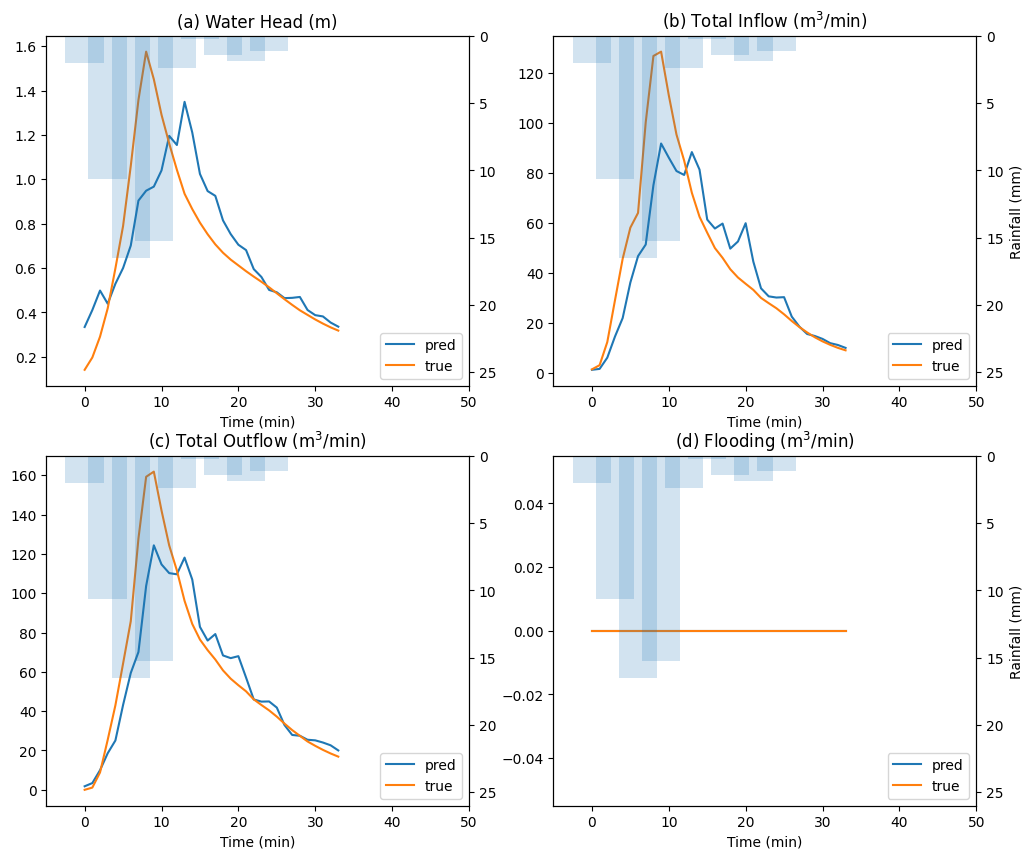

In [236]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
seq = 4
from envs import hague
env = hague()
nodes = env.get_features('nodes')
i = nodes.index('E144272')

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Head (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,i,idx],label='pred')
    ax.plot(true[:,seq,i,idx],label='true')
    # if idx == -1:
    #     ax.plot(r[:,seq,...,0].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain')
    # axx.plot(tide_ind,tide)
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)